### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List
import random
from matplotlib.gridspec import GridSpec

# Validation files

In [2]:
validation_set_closing_prices = pd.read_csv('Data/a5/data used/valid data/stocks.csv', sep=',')
display(validation_set_closing_prices.head())
currency_validation_set = pd.read_csv('Data/a5/data used/origin data/closing_prices_native_currency.csv', sep=';')
currency_validation_df = currency_validation_set[['Date', 'USD/EUR', 'JPY/EUR']]
display(currency_validation_df.head())
validation_set_closing_prices['Date'] = pd.to_datetime(validation_set_closing_prices['Date'], format='%Y/%m/%d')
# validation_set_closing_prices.set_index('Date', inplace=True)

,Date,AAPL(USD),MSFT(USD),ASML.AS(EUR),6758.T(JPY),VOW3.DE(EUR)
0,2010/4/6,7.208622,22.132381,30.082161,656.998840,35.649246
1,2010/4/7,7.240523,22.155024,30.076544,652.326050,35.413654
2,2010/4/8,7.220958,22.585293,29.576113,636.438416,34.536453
3,2010/4/9,7.276333,22.902338,29.980951,639.242127,34.436199
4,2010/4/12,7.291378,22.887228,29.682934,638.307434,34.185566


,Date,USD/EUR,JPY/EUR
0,06/04/2010,0.69493,0.00747
1,07/04/2010,0.69329,0.00750
2,08/04/2010,0.69609,0.00760
3,09/04/2010,0.69425,0.00752
4,12/04/2010,0.69842,0.00748


In [3]:
# Create log returns for validation set
# For AAPL and MSFT (USD)
validation_set_closing_prices['AAPL_Returns'] = np.log(validation_set_closing_prices['AAPL(USD)']) - np.log(validation_set_closing_prices['AAPL(USD)'].shift(1))
validation_set_closing_prices['MSFT_Returns'] = np.log(validation_set_closing_prices['MSFT(USD)']) - np.log(validation_set_closing_prices['MSFT(USD)'].shift(1))

# For ASML.AS and VOW3.DE (EUR)
validation_set_closing_prices['ASML_Returns'] = np.log(validation_set_closing_prices['ASML.AS(EUR)']) - np.log(validation_set_closing_prices['ASML.AS(EUR)'].shift(1))
validation_set_closing_prices['VOW3_Returns'] = np.log(validation_set_closing_prices['VOW3.DE(EUR)']) - np.log(validation_set_closing_prices['VOW3.DE(EUR)'].shift(1))

# For 6758.T (JPY)
validation_set_closing_prices['Sony_Returns'] = np.log(validation_set_closing_prices['6758.T(JPY)']) - np.log(validation_set_closing_prices['6758.T(JPY)'].shift(1))

validation_set_closing_prices['Return_USD/EUR'] = np.log(currency_validation_df['USD/EUR']) - np.log(currency_validation_df['USD/EUR'].shift(1))
validation_set_closing_prices['Return_JPY/EUR'] = np.log(currency_validation_df['JPY/EUR']) - np.log(currency_validation_df['JPY/EUR'].shift(1))

# Corrected returns
validation_set_closing_prices['C_AAPL_Returns'] = validation_set_closing_prices['AAPL_Returns'] - validation_set_closing_prices['Return_USD/EUR']
validation_set_closing_prices['C_MSFT_Returns'] = validation_set_closing_prices['MSFT_Returns'] - validation_set_closing_prices['Return_USD/EUR']
validation_set_closing_prices['C_ASML_Returns'] = validation_set_closing_prices['ASML_Returns']
validation_set_closing_prices['C_VOW3_Returns'] = validation_set_closing_prices['VOW3_Returns'] 
validation_set_closing_prices['C_Sony_Returns'] = validation_set_closing_prices['Sony_Returns'] - validation_set_closing_prices['Return_JPY/EUR']

display(validation_set_closing_prices.head())


,Date,AAPL(USD),MSFT(USD),ASML.AS(EUR),6758.T(JPY),VOW3.DE(EUR),AAPL_Returns,MSFT_Returns,ASML_Returns,VOW3_Returns,Sony_Returns,Return_USD/EUR,Return_JPY/EUR,C_AAPL_Returns,C_MSFT_Returns,C_ASML_Returns,C_VOW3_Returns,C_Sony_Returns
0,2010-04-06,7.208622,22.132381,30.082161,656.998840,35.649246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-04-07,7.240523,22.155024,30.076544,652.326050,35.413654,0.004416,0.001023,-0.000187,-0.006631,-0.007138,-0.002363,0.004008,0.006778,0.003385,-0.000187,-0.006631,-0.011146
2,2010-04-08,7.220958,22.585293,29.576113,636.438416,34.536453,-0.002706,0.019235,-0.016779,-0.025082,-0.024657,0.004031,0.013245,-0.006736,0.015204,-0.016779,-0.025082,-0.037902
3,2010-04-09,7.276333,22.902338,29.980951,639.242127,34.436199,0.007639,0.013940,0.013595,-0.002907,0.004396,-0.002647,-0.010582,0.010286,0.016587,0.013595,-0.002907,0.014978
4,2010-04-12,7.291378,22.887228,29.682934,638.307434,34.185566,0.002066,-0.000660,-0.009990,-0.007305,-0.001463,0.005989,-0.005333,-0.003923,-0.006648,-0.009990,-0.007305,0.003870


In [4]:
weights_validation = {
    'AAPL': 0.2,
    'MSFT': 0.2,
    'ASML.AS': 0.2,
    'VOW3.DE': 0.2,
    '6758.T': 0.2
}

initial_validation_investment = 1000000  # 1 million euros
equity_validation_investment = 600000
loan_validation_investment = 400000

starting_date = '06/04/2010'

starting_row_val = currency_validation_df[currency_validation_df['Date'] == starting_date]

validation_USD_TO_EUR = float(starting_row_val['USD/EUR'].iloc[0])
validation_JPY_TO_EUR = float(starting_row_val['JPY/EUR'].iloc[0])


loan_validation_set = pd.read_csv('Data/a5/data used/valid data/euribor_daily_rates.csv', sep=';')

#replace all the commas with dots
loan_validation_set = loan_validation_set.replace(',', '.', regex=True)
loan_validation_set['3m'] = pd.to_numeric(loan_validation_set['3m'])

year = 360
credit_spread = 0.015

# Calculate daily rate for each row
loan_validation_set['Daily_rate'] = ((loan_validation_set['3m'] / 100) + credit_spread) / year

validation_set_closing_prices['Loan_expenses'] = loan_validation_set['Daily_rate'].iloc[0] * loan_validation_investment

# Set initial investments for first row (index 0)

validation_set_closing_prices = (
    validation_set_closing_prices
    .reset_index(drop=True)    # make the index 0,1,2,...
)


validation_set_closing_prices.loc[0, 'AAPL_Investment'] = initial_validation_investment * weights_validation['AAPL']
validation_set_closing_prices.loc[0, 'MSFT_Investment'] = initial_validation_investment * weights_validation['MSFT']
validation_set_closing_prices.loc[0, 'ASML_Investment'] = initial_validation_investment * weights_validation['ASML.AS']
validation_set_closing_prices.loc[0, 'VOW3_Investment'] = initial_validation_investment * weights_validation['VOW3.DE']
validation_set_closing_prices.loc[0, 'Sony_Investment'] = initial_validation_investment * weights_validation['6758.T']


for i in range(1, len(validation_set_closing_prices)):
    validation_set_closing_prices.loc[i, 'AAPL_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'AAPL_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_AAPL_Returns'])
    validation_set_closing_prices.loc[i, 'MSFT_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'MSFT_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_MSFT_Returns'])
    validation_set_closing_prices.loc[i, 'ASML_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'ASML_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_ASML_Returns'])
    validation_set_closing_prices.loc[i, 'VOW3_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'VOW3_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_VOW3_Returns'])
    validation_set_closing_prices.loc[i, 'Sony_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'Sony_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_Sony_Returns'])

 
# build portfolio daily log‐return
validation_set_closing_prices['r_portfolio'] = (
      weights_validation['AAPL']    * validation_set_closing_prices['C_AAPL_Returns']
    + weights_validation['MSFT']    * validation_set_closing_prices['C_MSFT_Returns']
    + weights_validation['ASML.AS'] * validation_set_closing_prices['C_ASML_Returns']
    + weights_validation['VOW3.DE'] * validation_set_closing_prices['C_VOW3_Returns']
    + weights_validation['6758.T']  * validation_set_closing_prices['C_Sony_Returns']
)

# 1) make sure the columns exist (as floats) before your loop
validation_set_closing_prices['Total_investment'] = np.nan
validation_set_closing_prices['Total_investment_loan_correction'] = np.nan

# 2) set your initial values at row 0
validation_set_closing_prices.loc[0, 'Total_investment'] = initial_validation_investment
validation_set_closing_prices.loc[0, 'Total_investment_loan_correction'] = (
    initial_validation_investment - validation_set_closing_prices.loc[0, 'Loan_expenses']
)

# 3) now your loop will work without KeyErrors
for i in range(1, len(validation_set_closing_prices)):
    prev_val = validation_set_closing_prices.loc[i-1, 'Total_investment']
    r       = validation_set_closing_prices.loc[i,   'r_portfolio']
    new_val  = prev_val * np.exp(r)
    validation_set_closing_prices.loc[i, 'Total_investment'] = new_val

for i in range(1, len(validation_set_closing_prices)):
    # subtract that day’s loan expense
    prev_val = validation_set_closing_prices.loc[i-1, 'Total_investment_loan_correction']
    r = validation_set_closing_prices.loc[i, 'r_portfolio']
    exp = validation_set_closing_prices.loc[i, 'Loan_expenses']
    corrected_val = prev_val * np.exp(r) - exp
    validation_set_closing_prices.loc[i, 'Total_investment_loan_correction'] = corrected_val

# cols=['Total_investment', 'Total_investment_loan_correction']
# validation_set_closing_prices[cols].tail()



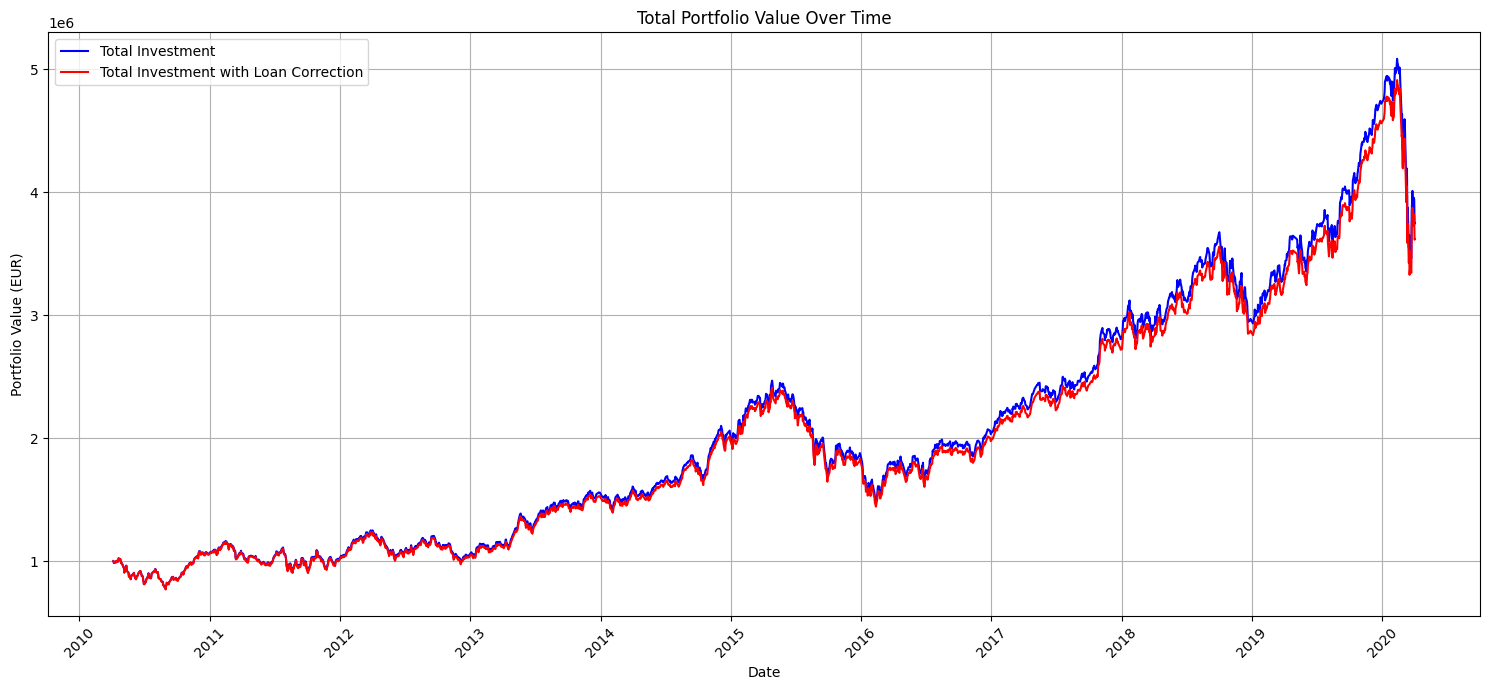

In [5]:
#plot the total portfolio returns over time
plt.figure(figsize=(15, 7))
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Total_investment'], label='Total Investment', color='blue')
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Total_investment_loan_correction'], label='Total Investment with Loan Correction', color='red')
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [6]:

#Calculate the loss per day per asset which is the difference between the investment of the previous day and the current day
validation_set_closing_prices['AAPL_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['AAPL'] * validation_set_closing_prices['C_AAPL_Returns'] * -1
validation_set_closing_prices['MSFT_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['MSFT'] * validation_set_closing_prices['C_MSFT_Returns'] * -1
validation_set_closing_prices['ASML_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['ASML.AS'] * validation_set_closing_prices['C_ASML_Returns'] * -1
validation_set_closing_prices['VOW3_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['VOW3.DE'] * validation_set_closing_prices['C_VOW3_Returns'] *-1
validation_set_closing_prices['Sony_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['6758.T'] * validation_set_closing_prices['C_Sony_Returns'] *-1

validation_set_closing_prices['MSFT_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['MSFT'] * validation_set_closing_prices['C_MSFT_Returns'] *-1
validation_set_closing_prices['AAPL_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['AAPL'] * validation_set_closing_prices['C_AAPL_Returns'] *-1
validation_set_closing_prices['ASML_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['ASML.AS'] * validation_set_closing_prices['C_ASML_Returns'] *-1
validation_set_closing_prices['VOW3_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['VOW3.DE'] * validation_set_closing_prices['C_VOW3_Returns'] *-1
validation_set_closing_prices['Sony_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['6758.T'] * validation_set_closing_prices['C_Sony_Returns'] *-1

#calculate the total loss per day
validation_set_closing_prices['Portfolio_Loss'] = (validation_set_closing_prices['AAPL_Loss'] + validation_set_closing_prices['MSFT_Loss'] + validation_set_closing_prices['ASML_Loss'] + validation_set_closing_prices['VOW3_Loss'] + validation_set_closing_prices['Sony_Loss']+ validation_set_closing_prices['Loan_expenses'])
validation_set_closing_prices['Portfolio_Loss_loan_correction'] = (validation_set_closing_prices['AAPL_Loss_loan_correction'] + validation_set_closing_prices['MSFT_Loss_loan_correction'] + validation_set_closing_prices['ASML_Loss_loan_correction'] + validation_set_closing_prices['VOW3_Loss_loan_correction'] + validation_set_closing_prices['Sony_Loss_loan_correction']+ validation_set_closing_prices['Loan_expenses'])

# Calculate the total portfolio value and return
validation_set_closing_prices['Total_Portfolio_Return'] = (validation_set_closing_prices['Total_investment'].pct_change(fill_method=None))
validation_set_closing_prices['Total_Portfolio_Return'] = validation_set_closing_prices['Total_Portfolio_Return'].fillna(0)

validation_set_closing_prices['Total_Portfolio_Return_loan_correction'] = (validation_set_closing_prices['Total_investment_loan_correction'].pct_change(fill_method=None))
validation_set_closing_prices['Total_Portfolio_Return_loan_correction'] = validation_set_closing_prices['Total_Portfolio_Return_loan_correction'].fillna(0)

display(validation_set_closing_prices.tail(10))

,Date,AAPL(USD),MSFT(USD),ASML.AS(EUR),6758.T(JPY),VOW3.DE(EUR),AAPL_Returns,MSFT_Returns,ASML_Returns,VOW3_Returns,...,Sony_Loss,MSFT_Loss_loan_correction,AAPL_Loss_loan_correction,ASML_Loss_loan_correction,VOW3_Loss_loan_correction,Sony_Loss_loan_correction,Portfolio_Loss,Portfolio_Loss_loan_correction,Total_Portfolio_Return,Total_Portfolio_Return_loan_correction
2337,2020-03-19,59.402966,136.598984,191.873276,1167.842407,53.875504,-0.007692,0.016319,0.078345,0.007313,...,11034.446232,-6039.357118,10150.757618,-52826.141414,-4930.716430,10658.263063,-44480.670835,-42963.438725,0.012832,0.012825
2338,2020-03-23,54.449886,130.157165,203.755051,1155.432983,56.580326,-0.087063,-0.048307,0.060083,0.048985,...,13458.488251,30482.581678,56405.467695,-40187.650507,-32764.611156,12999.572999,27909.997331,26959.116264,-0.008022,-0.008029
2339,2020-03-24,59.912598,141.987900,229.045502,1220.827637,67.356644,0.095606,0.086999,0.117002,0.174340,...,-39257.714676,-65413.103907,-71809.796026,-86956.819213,-129570.880517,-37918.840200,-405475.121430,-391645.684308,0.111155,0.111148
2340,2020-03-25,59.582546,140.628693,233.721802,1280.312866,70.460129,-0.005524,-0.009619,0.020211,0.045045,...,-39150.825292,10881.953894,7783.143128,-15295.286917,-34089.776509,-37815.358846,-70931.925604,-68511.569695,0.018277,0.018271
2341,2020-03-26,62.717968,149.425186,237.634689,1260.615723,69.736404,0.051285,0.060673,0.016603,-0.010325,...,10512.354650,-51747.948900,-44474.912031,-12863.317407,7998.985593,10153.707429,-94121.664124,-90909.729761,0.023752,0.023745
2342,2020-03-27,60.121304,143.289627,219.024734,1317.343506,64.657967,-0.042284,-0.041928,-0.081550,-0.075611,...,-36415.089269,30676.330003,30941.594811,60793.019876,56365.858806,-35172.501142,148701.367889,143628.057909,-0.037794,-0.037801
2343,2020-03-30,61.837044,153.368713,233.578674,1267.312866,64.412636,0.028138,0.067977,0.064334,-0.003802,...,34128.332703,-55473.286738,-25036.754954,-49151.120517,2904.331549,32963.570328,-97083.674313,-93769.504777,0.024857,0.024851
2344,2020-03-31,61.710838,150.956650,231.383636,1264.752197,65.528908,-0.002043,-0.015852,-0.009442,0.017182,...,3084.066143,14142.524903,3633.567999,7185.368795,-13075.378529,2978.791768,15413.974503,14888.630492,-0.003899,-0.003905
2345,2020-04-01,58.463799,145.596451,223.796509,1226.736572,60.720348,-0.054052,-0.036154,-0.033340,-0.076213,...,24252.472007,35246.506360,48183.542463,24098.896865,55088.272380,23424.461660,192641.656246,186065.435284,-0.050174,-0.050180
2346,2020-04-02,59.439365,148.611572,219.072433,1245.251953,60.616077,0.016549,0.020497,-0.021335,-0.001719,...,13527.947997,-19495.412498,-16636.507213,15448.365816,1244.505108,13066.000855,-6574.610844,-6349.292377,0.001762,0.001755


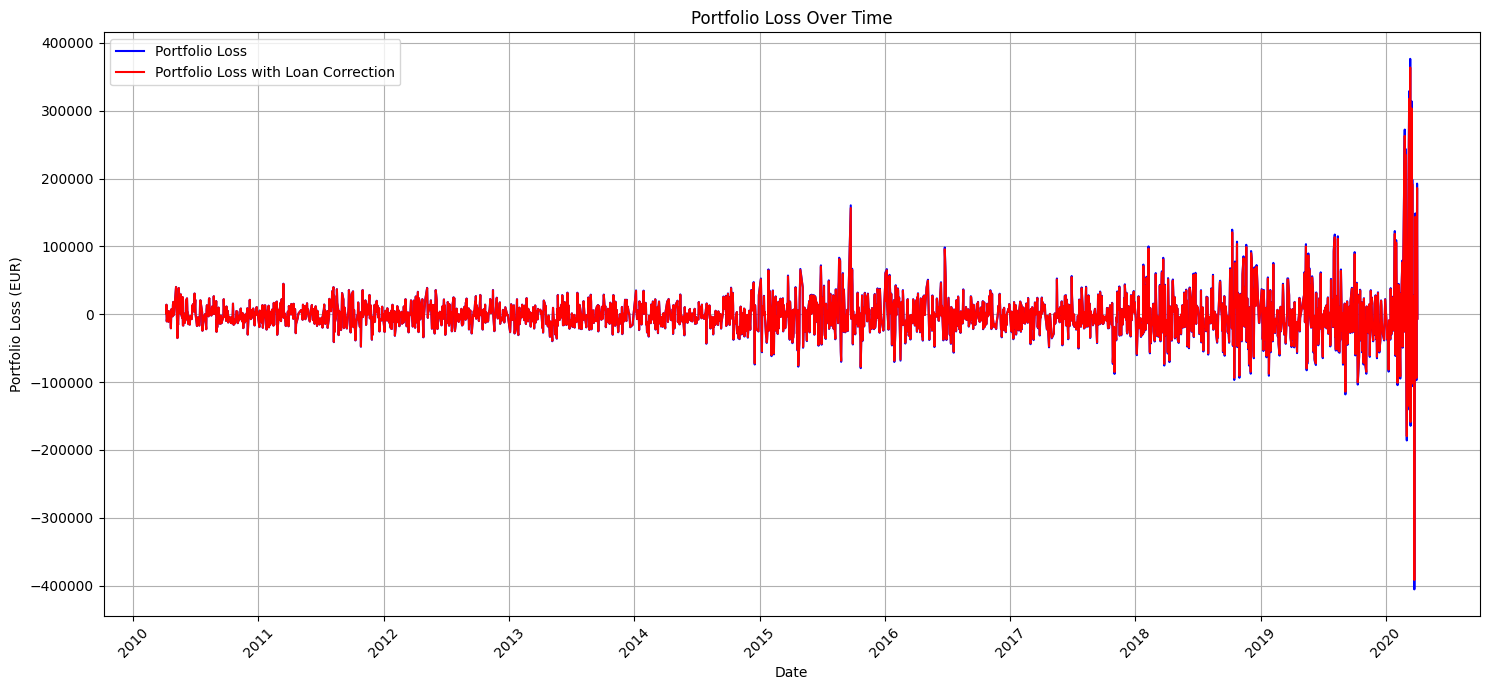

In [7]:
#make a plot with the portfolio loss and portfolio loss loan correction
plt.figure(figsize=(15, 7))
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Portfolio_Loss'], label='Portfolio Loss', color='blue')
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Portfolio_Loss_loan_correction'], label='Portfolio Loss with Loan Correction', color='red')
plt.title('Portfolio Loss Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Loss (EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Methods input values 

### Portfolio change Daily

In [8]:
# Replace instances of main_df with validation_set_closing_prices
if 'Portfolio_Daily_Returns' not in validation_set_closing_prices.columns:
    # Calculate the daily returns from existing return columns
    validation_set_closing_prices['Portfolio_Daily_Returns'] = (
        0.2 * validation_set_closing_prices['C_AAPL_Returns'] +
        0.2 * validation_set_closing_prices['C_MSFT_Returns'] +
        0.2 * validation_set_closing_prices['C_ASML_Returns'] +
        0.2 * validation_set_closing_prices['C_VOW3_Returns'] +
        0.2 * validation_set_closing_prices['C_Sony_Returns']
    )

In [9]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_Loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_Loss'])
    }
    return loss_dict

### Value at Risk (VaR)

In [10]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

### Expected Shortfall (ES) 

In [11]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## 1. var/cov multivar normal dist & T-distribution & Historical

### Required functions

In [12]:
def calculate_var_cov(current_date, vAlpha, mean_loss, portfolio_std_loss, df=0):
    """
    Calculate Value at Risk using variance-covariance method.
    
    Parameters:
    - window: DataFrame containing the time window
    - current_date: Current date for reporting
    - vAlpha: Confidence levels (array)
    - mean_loss: Mean loss for the portfolio
    - portfolio_std_loss: Standard deviation of losses
    - df: Degrees of freedom for t-distribution (0 for normal distribution)
    
    Returns:
    - Dictionary with date, VaR and ES values
    """
    # Calculate VaR and ES
    var_result = VaR(vAlpha, mean_loss, portfolio_std_loss, df=df)
    es_result = ES(vAlpha, mean_loss, portfolio_std_loss, df=df)
    
    # Set label for distribution type
    if df == 0:
        dist_label = "Normal"
    else:
        dist_label = f"T{df}"
        
    return {
        'Date': current_date,
        f'VaR {dist_label}': var_result,
        f'ES {dist_label}': es_result
    }

def calculate_historical_var_es(window, current_date, vAlpha):
    """
    Calculate VaR and ES using historical simulation method.
    """
    # Extract portfolio loss values from the window
    historical_losses = window['Portfolio_Loss'].dropna()
    
    # Sort losses in ascending order
    sorted_losses = np.sort(historical_losses)
    
    # Calculate VaR for alpha levels
    var_hist = np.percentile(sorted_losses, 100*vAlpha)
    
    # Calculate ES for each alpha level
    es_hist = []
    for i, alpha in enumerate(vAlpha):
        es_hist.append(sorted_losses[sorted_losses >= var_hist[i]].mean())
    
    return {
        'Date': current_date,
        'VaR Historical': var_hist,
        'ES Historical': es_hist
    }

def calculate_multiday_var(vAlpha, interval, sample_size):
    """
    Calculate multi-day VaR using the historical simulation method.

    Parameters:
    - vAlpha: Confidence levels (array)
    - interval: Number of days for the multi-day calculation (e.g., 5 or 10)
    - sample_size: Number of initial rows to skip (burn-in)

    Returns:
    - multi_day_losses_df: DataFrame with multi-day losses and VaR estimates
    """
    # Use validation_set_closing_prices as the main data source
    time_window_multi = validation_set_closing_prices[['Date', 'Portfolio_Loss']].dropna().reset_index(drop=True)
    multi_day_losses = []

    # Calculate rolling sum of losses over the interval, stepping by 'interval'
    for i in range(sample_size, len(time_window_multi) - interval + 1, interval):
        window = time_window_multi.iloc[i:i+interval]
        if len(window) == interval:
            total_loss = window['Portfolio_Loss'].sum()
            date = window['Date'].iloc[-1]
            daily_loss = window['Portfolio_Loss'].iloc[-1]
            multi_day_losses.append({'Date': date, 'Portfolio_Loss': total_loss, 'Daily_loss': daily_loss})

    multi_day_losses_df = pd.DataFrame(multi_day_losses)

    # Calculate VaR as percentiles of the historical multi-day losses up to each row
    var_list = []
    for idx in range(len(multi_day_losses_df)):
        hist_losses = multi_day_losses_df['Portfolio_Loss'][:idx+1]
        # For losses, VaR should be negative at high confidence, so use lower percentiles (100*(1-alpha))
        var_row = [np.percentile(hist_losses, 100 * (1 - alpha)) for alpha in vAlpha]
        var_list.append(var_row)
    multi_day_losses_df[f'VaR_{interval}d_reg'] = var_list

    # Calculate VaR per row using the square root of time rule for each alpha level
    sqrt_var_list = []
    for idx in range(len(multi_day_losses_df)):
        hist_daily_losses = multi_day_losses_df['Daily_loss'][:idx+1]
        sqrt_var_row = [np.percentile(hist_daily_losses, 100 * (1 - alpha)) * np.sqrt(interval) for alpha in vAlpha]
        sqrt_var_list.append(sqrt_var_row)
    multi_day_losses_df[f'VaR_{interval}d_sqrt'] = sqrt_var_list

    # drop the first row as it will not have a correct prediction
    multi_day_losses_df = multi_day_losses_df.iloc[1:]
    return multi_day_losses_df[['Date', 'Portfolio_Loss', f'VaR_{interval}d_reg', 'Daily_loss', f'VaR_{interval}d_sqrt']]


## GARCH(1,1) with constant conditional correlation 

In [13]:
#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [14]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.02, 0.13, 0.86],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result
    
# result = parameter_estimation_GARCH(main_df['Portfolio_Daily_Returns'].dropna())
# Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [15]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = [0.000002, 0.13, 0.86]
    param = type('obj', (object,), {'x': param})
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)

    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [16]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [17]:
def covariance_matrix(returns, corr_matrix):
    """
    Calculate the covariance matrix using GARCH(1,1) volatilities and a given correlation matrix.
    """
    # Calculate GARCH(1,1) volatilities for each column
    volatilities_dict = {}
    for column in returns.columns:
        column_returns = returns[column].dropna().reset_index(drop=True)
        volatilities_dict[column] = garch_volatility(column_returns)
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Construct the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    return cov_matrix

In [18]:
def portfolio_var_es_and_variance(weights, cov_matrix, alpha=0.99):
    """
    Calculate the portfolio variance, volatility, VaR, and ES using the normal distribution.

    Parameters:
    - weights: array-like, portfolio weights
    - cov_matrix: np.ndarray, covariance matrix
    - alpha: float, confidence level for VaR/ES (default 0.99)

    Returns:
    - dict with keys: 'variance', 'volatility', 'VaR', 'ES'
    """
    # Portfolio variance and volatility
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    port_volatility = np.sqrt(port_variance)

    # VaR and ES (normal distribution)
    VaR = -port_volatility * st.norm.ppf(alpha)
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))

    return VaR, ES

In [19]:
def compute_ewma_volatility(
    returns: pd.DataFrame, 
    lambdas: list = [0.94, 0.97]
) -> dict:
    """
    Compute EWMA volatility for each risk factor using different lambda values.
    Handles zeros and NaNs robustly.
    """
    if not isinstance(returns, pd.DataFrame):
        raise TypeError("returns must be a pandas DataFrame")
    if 'Date' in returns.columns:
        returns = returns.drop('Date', axis=1)
    results = {}
    for lambda_ in lambdas:
        n_obs, n_assets = returns.shape
        ewma_vol = np.zeros((n_obs, n_assets))
        ewma_vol[0] = returns.std().values
        for t in range(1, n_obs):
            ewma_vol[t] = np.sqrt(
                lambda_ * ewma_vol[t-1]**2 + 
                (1 - lambda_) * returns.iloc[t-1].values**2
            )
        # Replace zeros with small positive value, forward-fill NaNs
        ewma_vol = np.where(ewma_vol == 0, 1e-8, ewma_vol)
        ewma_vol_df = pd.DataFrame(
            ewma_vol, index=returns.index, columns=returns.columns
        ).ffill().bfill()
        results[f'lambda_{lambda_}'] = ewma_vol_df
    return results


# Example usage
returns_df = validation_set_closing_prices[['Date', 'C_AAPL_Returns', 'C_MSFT_Returns', 
                                            'C_ASML_Returns', 'C_VOW3_Returns', 'C_Sony_Returns']].dropna()
# set Date as index
returns_df.set_index('Date', inplace=True)
ewma_results = compute_ewma_volatility(returns_df)

In [20]:
# main function to run the GARCH analysis for the validation set
def main_analysis(time_window_size, vAlpha):
    """
    Rolling GARCH(1,1) VaR/ES analysis for the validation portfolio.
    Returns a DataFrame with Date, Portfolio VaR, Portfolio ES.
    """
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []

    # Use the validation set returns and weights
    returns = returns_df[['C_AAPL_Returns', 'C_MSFT_Returns', 'C_ASML_Returns', 'C_VOW3_Returns', 'C_Sony_Returns']]
    weights_arr = np.array([weights_validation['AAPL'], weights_validation['MSFT'],
                            weights_validation['ASML.AS'], weights_validation['VOW3.DE'],
                            weights_validation['6758.T']])

    for i in range(time_window_size, len(returns)):
        window = returns.iloc[i - time_window_size:i]
        current_date = returns.index[i]

        # Estimate correlation matrix from window
        corr_matrix = correlation_matrix(window.values)

        # Calculate GARCH(1,1) volatilities for each asset in the window
        cov_matrix = covariance_matrix(window, corr_matrix)

        VaR_list = []
        ES_list = []
        for alpha in vAlpha:
            VaR, ES = portfolio_var_es_and_variance(weights_arr, cov_matrix, alpha=alpha)
            VaR_list.append(VaR)
            ES_list.append(ES)

        portfolio_VaR_list.append(VaR_list)
        portfolio_ES_list.append(ES_list)
        dates.append(current_date)

    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list
    })
    return results_df


## EWMA

In [21]:
def calculate_monetary_values(var_df, es_df, main_df):
    """
    Returns two DataFrames containing only monetary VaR and ES columns,
    calculated by multiplying return-based values with portfolio values.
    """
    # Ensure datetime format and alignment
    var_df.index = pd.to_datetime(var_df.index)
    es_df.index = pd.to_datetime(es_df.index)
    main_df['Date'] = pd.to_datetime(main_df['Date'])

    # Align portfolio values to var_df index
    portfolio_values = main_df.loc[main_df['Date'].isin(var_df.index), 'Total_investment_loan_correction'].values

    # Create new DataFrames to hold only the monetary results
    monetary_var_df = pd.DataFrame(index=var_df.index)
    monetary_es_df = pd.DataFrame(index=es_df.index)

    # Add monetary VaR columns
    for col in var_df.columns:
        monetary_var_df[f'{col}'] = var_df[col] * portfolio_values *-1

    # Add monetary ES columns
    for col in es_df.columns:
        monetary_es_df[f'{col}'] = es_df[col] * portfolio_values *-1

    return monetary_var_df, monetary_es_df

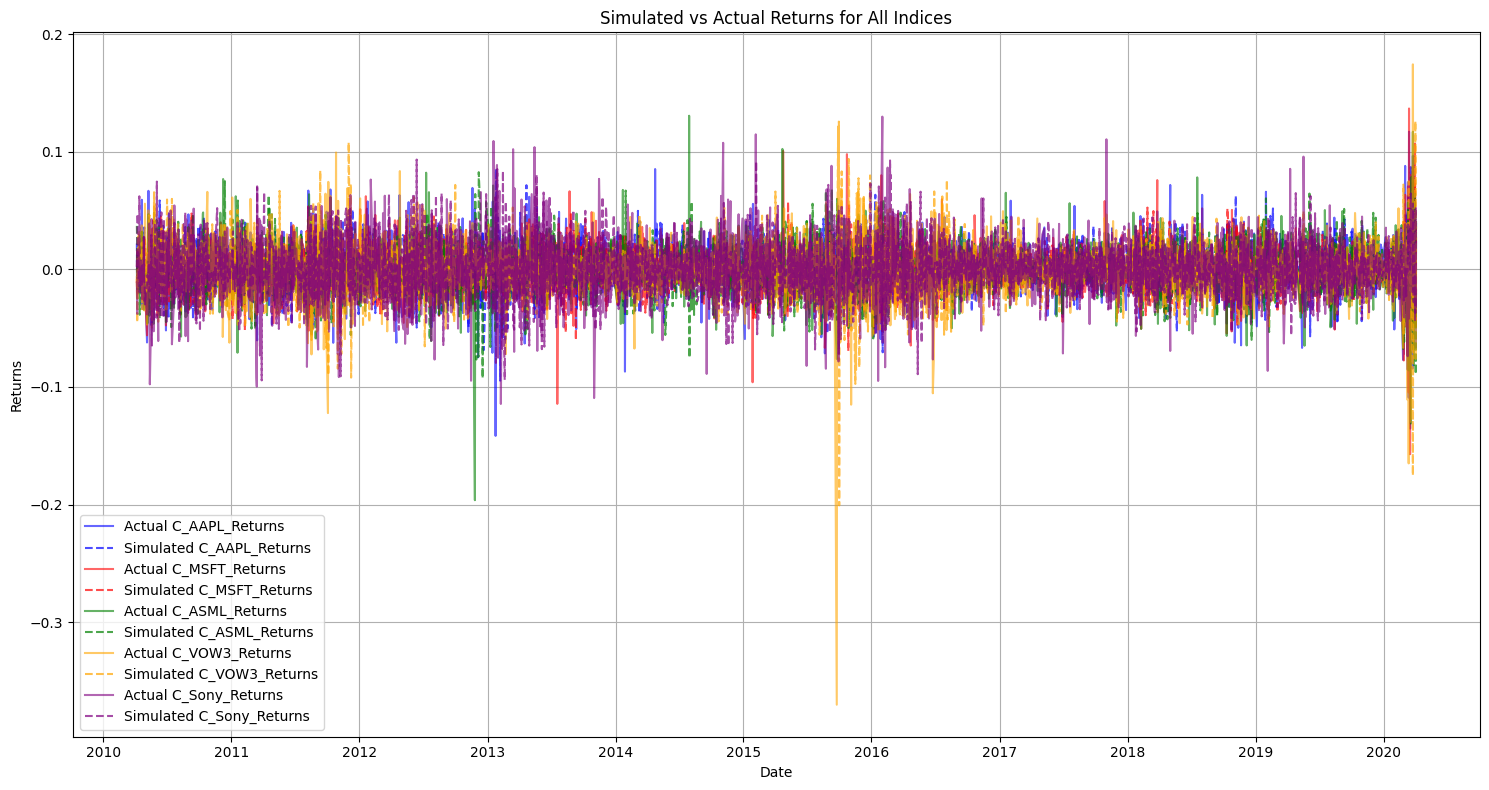

In [22]:
# Simulate returns using EWMA volatility for each index
simulated_returns = {}
for col in ['C_AAPL_Returns', 'C_MSFT_Returns', 'C_ASML_Returns', 'C_VOW3_Returns', 'C_Sony_Returns']:
    if col in ewma_results['lambda_0.94'].columns and col in returns_df.columns:
        simulated_returns[col] = pd.Series(
            np.random.normal(
                loc=0, 
                scale=ewma_results['lambda_0.94'][col].values, 
                size=len(ewma_results['lambda_0.94'])
            ),
            index=ewma_results['lambda_0.94'].index
        )

plt.figure(figsize=(15, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, col in enumerate(['C_AAPL_Returns', 'C_MSFT_Returns', 'C_ASML_Returns', 'C_VOW3_Returns', 'C_Sony_Returns']):
    if col in returns_df.columns and col in simulated_returns:
        # Plot actual returns
        plt.plot(returns_df.index, returns_df[col], label=f'Actual {col}', color=colors[i], alpha=0.6)
        # Plot simulated returns
        plt.plot(simulated_returns[col].index, simulated_returns[col], label=f'Simulated {col}', color=colors[i], linestyle='--', alpha=0.7)

plt.title('Simulated vs Actual Returns for All Indices')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#plot the actual returns and the simulated returns for all indices in one graph

In [23]:
def filter_returns(returns: pd.DataFrame, ewma_vol: dict) -> dict:
    """
    Compute standardized (filtered) returns for each lambda value.

    Parameters:
    - returns: DataFrame of raw returns
    - ewma_vol: Dictionary containing DataFrames of EWMA volatilities for each lambda

    Returns:
    - filtered_returns: Dictionary of DataFrames with standardized returns for each lambda
    """
    filtered_returns = {}
    
    # Filter returns for each lambda value
    for lambda_key, vol_df in ewma_vol.items():
        filtered_returns[lambda_key] = returns / vol_df
    
    return filtered_returns

# Assuming returns_df and ewma_vol_df (from compute_ewma_volatility) are already defined
filtered_returns_dict = filter_returns(returns_df, ewma_results)

# Preview results for both lambda values
print("\nFiltered Returns (lambda = 0.94):")
print(filtered_returns_dict['lambda_0.94'].tail())
print("\nFiltered Returns (lambda = 0.97):")
print(filtered_returns_dict['lambda_0.97'].tail())



Filtered Returns (lambda = 0.94):
            C_AAPL_Returns  C_MSFT_Returns  C_ASML_Returns  C_VOW3_Returns  \
Date                                                                         
2020-03-27       -0.677991       -0.651622       -1.559861       -1.094251   
2020-03-30        0.544195        1.170158        1.180843       -0.054693   
2020-03-31       -0.081018       -0.296230       -0.171289        0.254936   
2020-04-01       -1.166402       -0.799465       -0.623254       -1.163945   
2020-04-02        0.397744        0.446280       -0.406356       -0.025974   

            C_Sony_Returns  
Date                        
2020-03-27        1.516916  
2020-03-30       -1.336011  
2020-03-31       -0.118446  
2020-04-01       -1.011002  
2020-04-02       -0.562568  

Filtered Returns (lambda = 0.97):
            C_AAPL_Returns  C_MSFT_Returns  C_ASML_Returns  C_VOW3_Returns  \
Date                                                                         
2020-03-27       -0.8282

In [24]:
def filtered_historical_simulation_multiday(
    filtered_returns_dict: dict,
    ewma_vol_dict: dict,
    lambda_key: str,
    n_days: int = 1,
    n_simulations: int = 10000,
    random_seed: int = None,
    weights: np.ndarray = None
) -> pd.Series:
    """
    Simulate N-day portfolio returns using Filtered Historical Simulation.

    Returns:
    - Simulated N-day portfolio return series (n_simulations,)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    filtered_returns = filtered_returns_dict[lambda_key]
    ewma_vol = ewma_vol_dict[lambda_key]

    assets = filtered_returns.columns
    n_assets = len(assets)
    sim_returns = np.zeros((n_simulations, n_days, n_assets))

    for i, asset in enumerate(assets):
        z_asset = filtered_returns[asset].dropna().values
        sigma_t = ewma_vol[asset].iloc[-1]

        if len(z_asset) == 0 or np.isnan(sigma_t):
            raise ValueError(f"Cannot simulate for asset '{asset}': empty or invalid data.")

        for day in range(n_days):
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            sim_returns[:, day, i] = sigma_t * z_star

    # Combine all simulated daily returns into N-day portfolio PnL
    total_pnl = (sim_returns @ weights).sum(axis=1)

    return pd.Series(total_pnl, name=f"Simulated_{n_days}Day_Returns_{lambda_key}")

In [25]:
def rolling_fhs_multiday_var_es(
    returns_df: pd.DataFrame,
    weights: np.ndarray,
    window_size: int = 500,
    horizons: list = [1],
    confidence_levels: list = [0.95, 0.99],
    n_simulations: int = 1000,
    lambdas: list = [0.94, 0.97],
    random_seed: int = None
) -> tuple:
    """
    Rolling Filtered Historical Simulation for multi-day VaR & ES.
    """
    # Use the full available data range instead of hardcoded dates
    time_window = returns_df.copy()
    
    var_results = []
    es_results = []
    
    for t in range(window_size, len(time_window)):
        current_date = time_window.index[t]
        var_row = {'index': current_date}
        es_row = {'index': current_date}
        
        window = time_window.iloc[t - window_size:t]
        
        try:
            # Get column names dynamically from the dataframe
            return_cols = [col for col in returns_df.columns if 'Returns' in col]
            
            # Compute EWMA vol for the correct columns
            ewma_results = compute_ewma_volatility(window[return_cols], lambdas)
            
            # Filtered returns
            filtered_returns_dict = {}
            for lambda_key, vol_df in ewma_results.items():
                # Replace zeros with NaN and forward fill to avoid division by zero
                safe_vol_df = vol_df.replace(0, np.nan).ffill().bfill()
                filtered_returns = window[return_cols] / safe_vol_df
                filtered_returns_dict[lambda_key] = filtered_returns
            
            # Simulate for each lambda and confidence level
            for lambda_key in ewma_results.keys():
                # Get the appropriate weights array
                weights_array = np.array(list(weights.values()) if isinstance(weights, dict) else weights)
                
                # Make sure weights array length matches number of return columns
                if len(weights_array) != len(return_cols):
                    # If using dictionary weights, match them by extracting the appropriate values
                    if isinstance(weights, dict):
                        weights_keys = list(weights.keys())
                        weights_array = np.array([weights.get(key, 0.0) for key in 
                                               [key.split('_')[0] for key in return_cols]])
                
                for horizon in horizons:
                    sim_returns = filtered_historical_simulation_multiday(
                        filtered_returns_dict,
                        ewma_results,
                        lambda_key,
                        n_days=horizon,
                        n_simulations=n_simulations,
                        weights=weights_array,
                        random_seed=random_seed
                    )
                    
                    for cl in confidence_levels:
                        alpha = 1 - cl
                        var = np.percentile(sim_returns, 100 * alpha)
                        # Handle case where no values are below VaR
                        below_var = sim_returns[sim_returns <= var]
                        es = below_var.mean() if len(below_var) > 0 else var
                        
                        var_key = f"VaR_{int(cl * 100)}_{lambda_key}_h{horizon}"
                        es_key = f"ES_{int(cl * 100)}_{lambda_key}_h{horizon}"
                        
                        var_row[var_key] = var
                        es_row[es_key] = es
            
            var_results.append(var_row)
            es_results.append(es_row)
            
        except Exception as e:
            print(f"Error at date {current_date}: {e}")
            continue
    
    var_df = pd.DataFrame(var_results).set_index('index')
    es_df = pd.DataFrame(es_results).set_index('index')
    
    var_df.index.name = 'Date'
    es_df.index.name = 'Date'
    
    return var_df, es_df

In [26]:
returns_df = validation_set_closing_prices[['Date', 'C_AAPL_Returns', 'C_MSFT_Returns', 
                                            'C_ASML_Returns', 'C_VOW3_Returns', 'C_Sony_Returns']].dropna()
# set Date as index
returns_df.set_index('Date', inplace=True)

# var_df, es_df = rolling_fhs_multiday_var_es(
#     returns_df,
#     weights_validation,
#     window_size=500,
#     horizons=[1],
#     confidence_levels=[0.95, 0.99],
#     n_simulations=10000,
#     lambdas=[0.94, 0.97],
#     random_seed=42
# )

# # Calculate monetary values for VaR and ES
# monetary_var_df, monetary_es_df = calculate_monetary_values(var_df, es_df, validation_set_closing_prices)
# # Display the monetary VaR and ES DataFrames
# display(monetary_var_df.tail())
# display(monetary_es_df.tail())

In [27]:
def plot_var_es_vs_actual_given_actuals(var_df, es_df, actual_returns_dict, lambdas, horizons, confidence_levels):
    """
    Plot VaR and ES against already computed actual portfolio returns and mark violations.

    Parameters:
    - var_df: DataFrame of rolling VaR values
    - es_df: DataFrame of rolling ES values
    - actual_returns_dict: Dict of actual portfolio return Series keyed by horizon
    - lambdas: list of lambda values used (e.g. [0.94, 0.97])
    - horizons: list of horizon days (e.g. [1, 5, 10])
    - confidence_levels: list of confidence levels (e.g. [0.95, 0.99])
    """

    for h in horizons:
        actual_returns = actual_returns_dict[h].reindex(var_df.index).sort_index()
        actual_returns = actual_returns[~actual_returns.index.duplicated(keep='first')]  

        for lambda_ in lambdas:
            lambda_key = f"lambda_{lambda_}"
            plt.figure(figsize=(14, 5))
            plt.plot(actual_returns, label="Actual Portfolio Return", alpha=0.6)

            title_addon = ""

            for cl in confidence_levels:
                var_col = f"VaR_{int(cl * 100)}_{lambda_key}_h{h}"
                var_series = var_df[var_col]
                plt.plot(var_series, label=f"VaR {int(cl * 100)}%", linestyle='--')

                # Find violations
                actual_aligned, var_aligned = actual_returns.align(var_series, join='inner')
                violations = actual_aligned < var_aligned
                violation_points = actual_aligned[violations]


                # Mark violations with different styles
                if cl == 0.95:
                    plt.scatter(violation_points.index, violation_points, 
                                color='red', label="VaR 95% Violation", marker='x', s=50)
                elif cl == 0.99:
                    plt.scatter(violation_points.index, violation_points, 
                                color='purple', label="VaR 99% Violation", marker='v', s=60)

                # Count violations and append to title
                total_obs = actual_returns.dropna().shape[0]
                violation_count = len(violation_points)
                percentage = violation_count / total_obs * 100
                title_addon += f" | {int(cl*100)}% Viol: {violation_count} ({percentage:.2f}%)"

            plt.title(f"{h}-Day VaR and ES vs Actual Returns | λ={lambda_}{title_addon}")
            plt.axhline(0, color='gray', linestyle='-')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


# Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [28]:
def calculate_violations(negative_actual_returns, var_predictions):
    """Checks for VaR violations. Violation occurs if negative return is less than negative VaR."""
    # var_predictions are typically positive loss values, so compare negative return to -VaR
    return negative_actual_returns < -var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    # Expected violations based on the confidence level (1 - alpha)
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(negative_actual_returns, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(negative_actual_returns, pd.Series):
        negative_actual_returns = pd.Series(negative_actual_returns, index=dates)
    elif negative_actual_returns.index.name != 'Date':
        negative_actual_returns = negative_actual_returns.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Negative_Return': negative_actual_returns,
        'Violation': violations,
        'Predicted_ES': es_predictions, # Assumed positive loss value
        'Year': negative_actual_returns.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    # Actual shortfall is the loss on violation days, which is -Negative_Return
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Negative_Return'].apply(lambda x: -x.mean())
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    # Handle years with no violations (results in NaN means)
    summary = summary.fillna({'Avg Actual Shortfall': 0, 'Avg Predicted ES': 0})
    return summary

def calculate_violation_spacing(violations, dates):
    """Calculate the spacing between consecutive violations."""
    # Ensure violations and dates are aligned
    violation_dates = pd.Series(dates[violations])
    
    if len(violation_dates) <= 1:
        return []  # Not enough violations to calculate spacing
        
    # Calculate days between consecutive violations
    spacing = [(violation_dates.iloc[i] - violation_dates.iloc[i-1]).days 
               for i in range(1, len(violation_dates))]
    
    return spacing

def plot_violation_spacing_qq(violations_dict, model_name, alpha):
    """Create QQ plot for the spacing between violations."""
    # Set up the figure
    plt.figure(figsize=(8, 6))
    
    for method, (violations, dates) in violations_dict.items():
        # Get spacing between violations
        spacing = calculate_violation_spacing(violations, dates)
        
        if not spacing:
            continue  # Skip if not enough violations
            
        # Calculate theoretical quantiles for exponential distribution
        # For independent violations at rate (1-alpha), spacing should follow Exp(1-alpha)
        n = len(spacing)
        p = np.arange(1, n + 1) / (n + 1)  # Empirical probabilities
        theoretical_quantiles = -np.log(1 - p) / (1 - alpha)  # Exponential quantiles
        
        # Sort the observed spacings
        observed_quantiles = sorted(spacing)
        
        # Plot the QQ plot
        plt.scatter(theoretical_quantiles, observed_quantiles, 
                   label=f"{method}", alpha=0.7)
    
    # Add reference line (y=x)
    max_val = max([max(theoretical_quantiles) for theoretical_quantiles, _ 
                  in [(theoretical_quantiles, spacing) 
                     for _, (violations, dates) in violations_dict.items() 
                     if calculate_violation_spacing(violations, dates)]], 
                 default=10)
    plt.plot([0, max_val], [0, max_val], 'r--', label='Expected')
    
    plt.title(f'QQ Plot of VaR Violation Spacing - {model_name} (alpha={alpha})')
    plt.xlabel('Theoretical Quantiles (Exponential Distribution)')
    plt.ylabel('Observed Spacing (Days)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models and creates consolidated tables."""
    # Align main_df with var/es results (which start after the initial window)
    if 'Date' not in var_results_df.columns or 'Date' not in es_results_df.columns or 'Date' not in main_df.columns:
        raise ValueError("All input DataFrames must contain a 'Date' column.")
        
    # Use merge to ensure alignment and handle potential missing dates
    backtest_base = pd.merge(var_results_df[['Date']], main_df[['Date', 'Portfolio_loss']], on='Date', how='left')
    backtest_base = backtest_base.set_index('Date')
    
    # Calculate negative actual returns
    negative_actual_returns = -backtest_base['Portfolio_loss']
    backtest_dates = negative_actual_returns.index # Use index from aligned data

    # Confidence levels used (assuming 95% and 99%)
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Ensure Date columns are handled correctly
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    
    # Align var_results_df and es_results_df to the backtest_dates
    var_results_aligned = var_results_df.set_index('Date').reindex(backtest_dates)
    es_results_aligned = es_results_df.set_index('Date').reindex(backtest_dates)

    # Create consolidated tables for each alpha level
    for alpha in alphas:
        alpha_idx = alpha_indices[alpha]
        
        # Create dictionaries to store violations by year for each method
        yearly_violations = {}
        violations_for_qq = {}
        
        # Get all unique years in the dataset
        all_years = pd.Series(backtest_dates).dt.year.unique()
        
        print(f"\n--- Backtesting Results for Confidence Level: {alpha*100}% ---\n")
        
        # Process each model
        for model_name in var_model_cols:
            try:
                # Extract predictions for this model at this alpha level
                var_preds_list = var_results_aligned[model_name].tolist()
                var_predictions = pd.Series([p[alpha_idx] if isinstance(p, (list, np.ndarray)) and len(p) > alpha_idx 
                                           else np.nan for p in var_preds_list], index=backtest_dates)
                
                # Drop NaN predictions and align actual returns
                valid_idx = var_predictions.notna()
                var_predictions_clean = var_predictions[valid_idx]
                negative_actual_returns_clean = negative_actual_returns[valid_idx]
                backtest_dates_clean = backtest_dates[valid_idx]
                
                if negative_actual_returns_clean.empty:
                    print(f"  Warning: No valid data points for {model_name}. Skipping.")
                    continue
                
                # Calculate violations
                violations = calculate_violations(negative_actual_returns_clean, var_predictions_clean)
                
                # Get VaR backtest summary by year
                var_summary = backtest_var(violations, alpha, backtest_dates_clean)
                
                # Store violations by year for this method
                yearly_violations[model_name] = var_summary['Actual Violations']
                
                # Store violations and dates for QQ plot
                violations_for_qq[model_name] = (violations.values, backtest_dates_clean)
                
            except Exception as e:
                print(f"  Error processing {model_name} for alpha={alpha}: {e}")
        
        # Create a consolidated dataframe for all models
        if yearly_violations:
            # Create a DataFrame with all years as index
            violations_df = pd.DataFrame(index=all_years)
            
            # Add violations for each method
            for model_name, violations in yearly_violations.items():
                violations_df[model_name] = violations
                
            # Add expected violations column (same for all methods at given alpha)
            yearly_counts = backtest_base.groupby(backtest_base.index.year)['Portfolio_loss'].count()
            violations_df['Expected Violations'] = yearly_counts * (1 - alpha)
            
            # Fill NaN with 0 (years with no violations)
            violations_df = violations_df.fillna(0)
            
            # Display the consolidated table
            print(f"\nAnnual VaR Violations Table ({alpha*100}% Confidence Level):")
            display(violations_df)
            
            # Create QQ plot for violation spacing
            plot_violation_spacing_qq(violations_for_qq, "All Models", alpha)
        else:
            print(f"No valid violation data available for alpha={alpha}")

    return None  # No return value needed

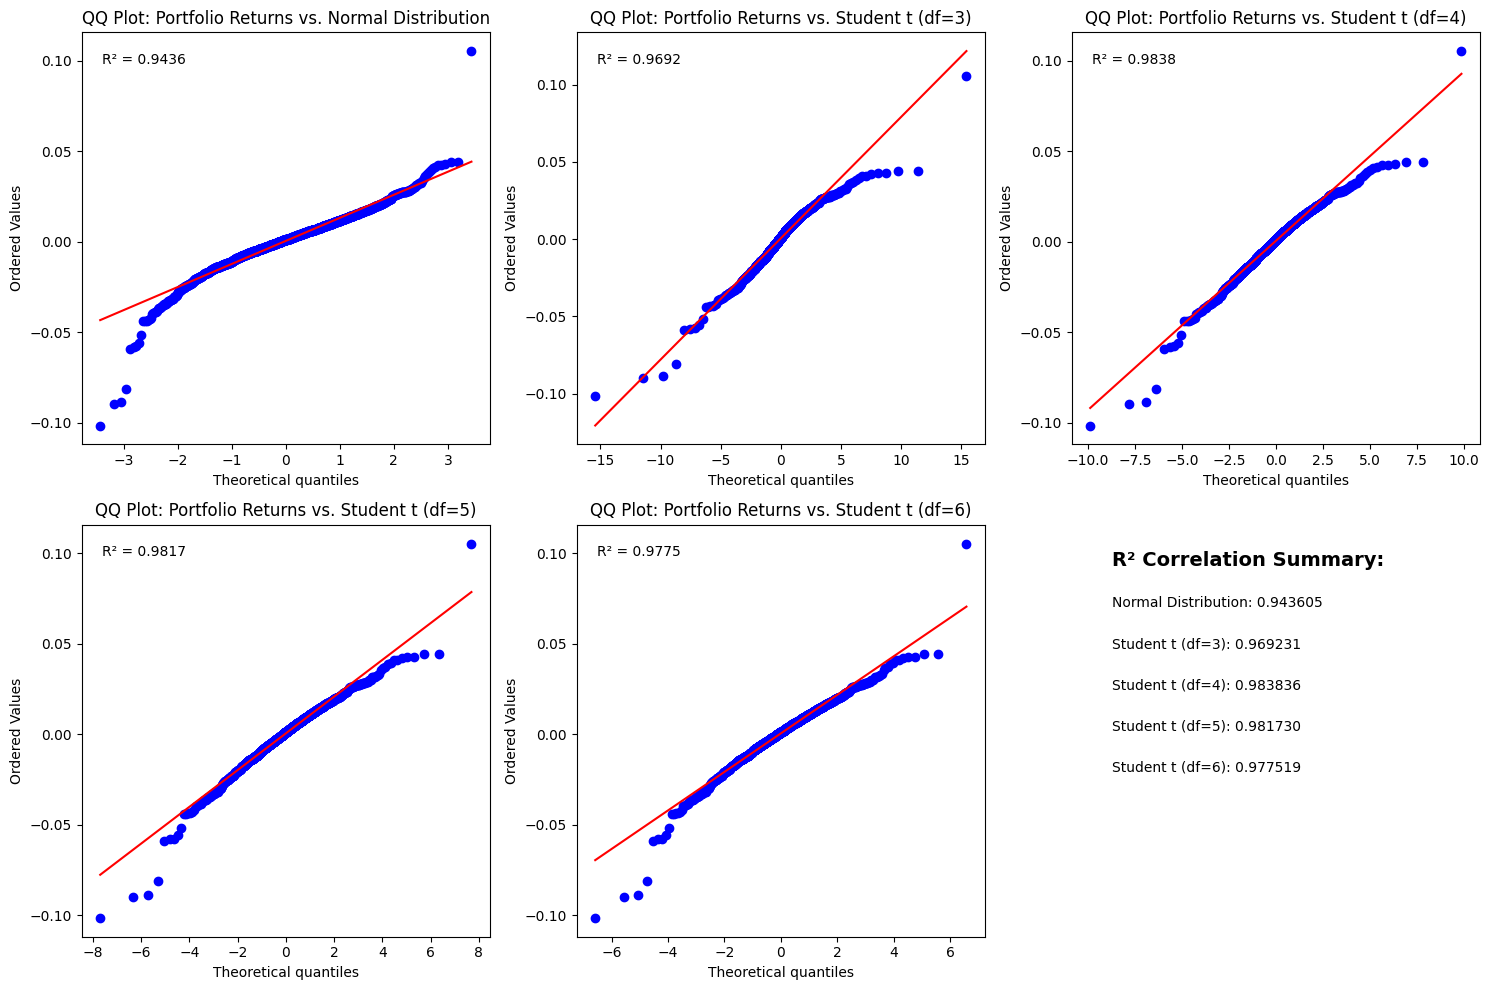

In [29]:
# Use Portfolio_Daily_Returns from validation_set_closing_prices
portfolio_returns = validation_set_closing_prices['Portfolio_Daily_Returns'].dropna()

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

# QQ plot for normal distribution
ax1 = fig.add_subplot(gs[0, 0])
res1 = st.probplot(portfolio_returns, dist='norm', plot=ax1)
ax1.set_title('QQ Plot: Portfolio Returns vs. Normal Distribution')
r_squared_normal = np.corrcoef(res1[0][0], res1[0][1])[0, 1]**2
ax1.text(0.05, 0.95, f'R² = {r_squared_normal:.4f}', transform=ax1.transAxes, verticalalignment='top')

dfs = [3, 4, 5, 6]
r_squared_values = {}

def t_dist_generator(df):
    return st.t(df=df)

# QQ plot for t distribution with df=3
ax2 = fig.add_subplot(gs[0, 1])
t3 = t_dist_generator(dfs[0])
res2 = st.probplot(portfolio_returns, dist=t3, plot=ax2)
ax2.set_title(f'QQ Plot: Portfolio Returns vs. Student t (df={dfs[0]})')
r_squared_t3 = np.corrcoef(res2[0][0], res2[0][1])[0, 1]**2
r_squared_values[dfs[0]] = r_squared_t3
ax2.text(0.05, 0.95, f'R² = {r_squared_t3:.4f}', transform=ax2.transAxes, verticalalignment='top')

# QQ plot for t distribution with df=4
ax3 = fig.add_subplot(gs[0, 2])
t4 = t_dist_generator(dfs[1])
res3 = st.probplot(portfolio_returns, dist=t4, plot=ax3)
ax3.set_title(f'QQ Plot: Portfolio Returns vs. Student t (df={dfs[1]})')
r_squared_t4 = np.corrcoef(res3[0][0], res3[0][1])[0, 1]**2
r_squared_values[dfs[1]] = r_squared_t4
ax3.text(0.05, 0.95, f'R² = {r_squared_t4:.4f}', transform=ax3.transAxes, verticalalignment='top')

# QQ plot for t distribution with df=5
ax4 = fig.add_subplot(gs[1, 0])
t5 = t_dist_generator(dfs[2])
res4 = st.probplot(portfolio_returns, dist=t5, plot=ax4)
ax4.set_title(f'QQ Plot: Portfolio Returns vs. Student t (df={dfs[2]})')
r_squared_t5 = np.corrcoef(res4[0][0], res4[0][1])[0, 1]**2
r_squared_values[dfs[2]] = r_squared_t5
ax4.text(0.05, 0.95, f'R² = {r_squared_t5:.4f}', transform=ax4.transAxes, verticalalignment='top')

# QQ plot for t distribution with df=6
ax5 = fig.add_subplot(gs[1, 1])
t6 = t_dist_generator(dfs[3])
res5 = st.probplot(portfolio_returns, dist=t6, plot=ax5)
ax5.set_title(f'QQ Plot: Portfolio Returns vs. Student t (df={dfs[3]})')
r_squared_t6 = np.corrcoef(res5[0][0], res5[0][1])[0, 1]**2
r_squared_values[dfs[3]] = r_squared_t6
ax5.text(0.05, 0.95, f'R² = {r_squared_t6:.4f}', transform=ax5.transAxes, verticalalignment='top')

# Summary subplot
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')
ax6.text(0.1, 0.9, 'R² Correlation Summary:', fontsize=14, fontweight='bold')
ax6.text(0.1, 0.8, f'Normal Distribution: {r_squared_normal:.6f}')
ax6.text(0.1, 0.7, f'Student t (df=3): {r_squared_t3:.6f}')
ax6.text(0.1, 0.6, f'Student t (df=4): {r_squared_t4:.6f}')
ax6.text(0.1, 0.5, f'Student t (df=5): {r_squared_t5:.6f}')
ax6.text(0.1, 0.4, f'Student t (df=6): {r_squared_t6:.6f}')

best_fit = max(r_squared_values.items(), key=lambda x: x[1])
best_fit_text = f'Best fit: Student t with df={best_fit[0]} (R²={best_fit[1]:.6f})'

plt.tight_layout()
plt.show()


# MAIN FUNCTION

In [30]:
def main():
    # Initialize lists to store results
    VaR_results = []
    ES_results = []
    
    # Use the full validation set date range consistently for all methods
    time_window = validation_set_closing_prices
    
    # Define confidence levels
    vAlpha = np.array([0.95, 0.99])
    
    # Define sample size and t-distribution degrees of freedom
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6]  # 0 represents normal distribution
    
    for i in range(sample_size, len(time_window)):
        # Extract the rolling window
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate loss statistics
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"]
        
        # Initialize result dictionaries for this date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}

        # Calculate VaR and ES using various distributions
        for df in degrees_of_freedom:
            results = calculate_var_cov(current_date, vAlpha, mean_loss, portfolio_std_loss, df)
            # Get the distribution label
            if df == 0:
                dist_label = "Normal"
            else:
                dist_label = f"T{df}"
            # Add results to the dictionaries
            var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
            es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
        
        # Calculate VaR and ES using historical simulation
        hist_results = calculate_historical_var_es(window, current_date, vAlpha)
        var_row['VaR Historical'] = hist_results['VaR Historical']
        es_row['ES Historical'] = hist_results['ES Historical']
        
        # Add results for this date
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert results to DataFrame
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    # Use the same date range for rolling FHS calculation
    returns_df = validation_set_closing_prices[['Date', 'C_AAPL_Returns', 'C_MSFT_Returns', 
                                              'C_ASML_Returns', 'C_VOW3_Returns', 'C_Sony_Returns']].dropna()
    # set Date as index
    returns_df.set_index('Date', inplace=True)

    # Calculate VaR and ES using rolling FHS - use same data range as above
    var_df, es_df = rolling_fhs_multiday_var_es(
        returns_df=returns_df,  # DataFrame containing returns
        weights=weights_validation,  # Use validation weights
        window_size=500,       # Base window size
        horizons=[1],   # Horizons for VaR calculation
        confidence_levels=[0.95, 0.99],  # Confidence levels
        n_simulations=1000,    # Number of simulations
        lambdas=[0.94, 0.97]   # EWMA lambda values
    )

    # Align indices for merging
    var_results_df = var_results_df.copy()
    es_results_df = es_results_df.copy()

    # Ensure 'Date' is datetime and set as index for alignment
    var_results_df['Date'] = pd.to_datetime(var_results_df['Date'])
    es_results_df['Date'] = pd.to_datetime(es_results_df['Date'])
    var_results_df.set_index('Date', inplace=True)
    es_results_df.set_index('Date', inplace=True)

    # Add FHS VaR and ES columns as lists [95, 99] for each lambda
    for lambda_ in [0.94, 0.97]:
        var_col_95 = f'VaR_95_lambda_{lambda_}_h1'
        var_col_99 = f'VaR_99_lambda_{lambda_}_h1'
        es_col_95 = f'ES_95_lambda_{lambda_}_h1'
        es_col_99 = f'ES_99_lambda_{lambda_}_h1'

        # compute monetary values
        var_df_corrected, es_df_corrected = calculate_monetary_values(var_df, es_df, validation_set_closing_prices)

        # Align var_df/es_df to var_results_df by Date
        aligned_var = var_df_corrected.reindex(var_results_df.index)[[var_col_95, var_col_99]]
        aligned_es = es_df_corrected.reindex(es_results_df.index)[[es_col_95, es_col_99]]

        # Combine [95,99] into a list for each row
        var_results_df[f'VaR FHS λ={lambda_}'] = aligned_var.values.tolist()
        es_results_df[f'ES FHS λ={lambda_}'] = aligned_es.values.tolist()

    # Reset index to restore 'Date' as a column
    var_results_df.reset_index(inplace=True)
    es_results_df.reset_index(inplace=True)

    # Insert the GARCH values into var_results_df and es_results_df using the main_analysis function
    garch_results_df = main_analysis(500, vAlpha=vAlpha)

    # Ensure 'Date' is datetime for alignment
    garch_results_df['Date'] = pd.to_datetime(garch_results_df['Date'])

    # Convert to monetary values by multiplying by the portfolio value
    portfolio_value = validation_set_closing_prices['Total_investment_loan_correction'].iloc[-len(garch_results_df):].values
    garch_results_df['Portfolio VaR'] = [
        [v * pv * -1 for v in var_list] for var_list, pv in zip(garch_results_df['Portfolio VaR'], portfolio_value)
    ]
    garch_results_df['Portfolio ES'] = [
        [v * pv * -1 for v in es_list] for es_list, pv in zip(garch_results_df['Portfolio ES'], portfolio_value)
    ]

    # Align GARCH results to var_results_df by Date
    aligned_garch = garch_results_df.set_index('Date').reindex(var_results_df['Date'])

    # Add GARCH VaR and ES columns as lists [95, 99] for each row
    var_results_df['VaR GARCH'] = aligned_garch['Portfolio VaR'].tolist()
    es_results_df['ES GARCH'] = aligned_garch['Portfolio ES'].tolist()

    var_5d = calculate_multiday_var(vAlpha, 5, sample_size)
    var_10d = calculate_multiday_var(vAlpha, 10, sample_size)

    return var_results_df, es_results_df, var_5d, var_10d

In [31]:
var_results_df, es_results_df, var_5d, var_10d = main()
print("VaR results")
display(var_results_df.head())
print("ES results")
display(es_results_df.head())
print("5-day VaR results")
display(var_5d.head())
print("10-day VaR results")
display(var_10d.head())

VaR results


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6,VaR Historical,VaR FHS λ=0.94,VaR FHS λ=0.97,VaR GARCH
0,2012-05-23,"[23078.87471177207, 32748.448210684983]","[19018.916209815823, 36937.37606408191]","[21129.18976972421, 37333.46853734955]","[21886.962109193286, 36722.94882590104]","[22252.32746452726, 36148.50798537133]","[23038.77171090293, 37065.68063974448]","[nan, nan]","[nan, nan]",NaN
1,2012-05-24,"[23103.6186567051, 32772.25788126844]","[19044.052428005696, 36960.78100038767]","[21154.122093248217, 37356.83520319408]","[21911.821216741464, 36746.37448017007]","[22277.151270468832, 36171.98914212376]","[23015.253953823823, 37049.39729040541]","[18650.03579563944, 27507.349939758224]","[17698.574844331753, 26826.118719901424]","[25872.562737476488, 36592.05921676363]"
2,2012-05-25,"[23098.883788501866, 32767.37111362073]","[19039.38133773859, 36955.82842882277]","[21149.417852668797, 37351.87640940783]","[21907.105072307397, 36741.425277045186]","[22272.42938650608, 36167.04896289684]","[23015.253953823823, 37049.39729040541]","[17916.1952347702, 24772.48416065104]","[17447.97104956826, 24739.751182860182]","[25776.80635229824, 36456.629133846094]"
3,2012-05-29,"[23096.643809075034, 32764.55555624213]","[19037.383025909516, 36952.76352699126]","[21147.29392755043, 37348.787930311555]","[21904.936041057812, 36738.373138919385]","[22270.238607012594, 36164.03101815945]","[23015.253953823823, 37049.39729040541]","[18696.12303388953, 26303.039261689213]","[16468.18357883986, 24771.39685797731]","[25016.30725838727, 35381.04075239921]"
4,2012-05-30,"[23140.618537661594, 32841.68077222912]","[19067.43887760037, 37044.249769350405]","[21184.584493064704, 37441.63210831759]","[21944.824500098086, 36829.12425397861]","[22311.37965900435, 36252.812760541754]","[23015.253953823823, 37049.39729040541]","[18154.41705665944, 26002.307747326293]","[16979.343213988785, 26270.864397233625]","[24168.777311879527, 34182.36297527782]"


ES results


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6,ES Historical,ES FHS λ=0.94,ES FHS λ=0.97,ES GARCH
0,2012-05-23,"[29007.787649538153, 37556.54902136467]","[31478.006215255682, 57108.93333136369]","[31874.752751274686, 52118.443287761314]","[31504.608212542997, 48675.19862907015]","[31144.56093481103, 46457.6097644474]","[32199.81704845197, 40609.13212136179]","[nan, nan]","[nan, nan]",NaN
1,2012-05-24,"[29031.958742806193, 37579.89413316918]","[31501.93863596551, 57130.389291476466]","[31898.646838327717, 52140.381429103705]","[31528.53806296741, 48697.469456767765]","[31168.525573009305, 46480.094855617375]","[32199.81704845197, 40609.13212136179]","[24064.45520797285, 31270.504865066676]","[22799.862845908392, 30069.772531952865]","[32445.237465015256, 41922.22395649418]"
2,2012-05-25,"[29027.130737239488, 37574.93183500897]","[31497.071825706138, 57125.11984467986]","[31893.773795572313, 52135.19037797422]","[31523.670834816945, 48692.33249560935]","[31163.664000845787, 46474.99273058867]","[32199.81704845197, 40609.13212136179]","[22785.315123482826, 31528.742512232584]","[22370.62002697414, 29772.551107017836]","[32325.155094844813, 41767.06651556189]"
3,2012-05-29,"[29024.537841361343, 37571.83007712557]","[31494.33189093919, 57120.85423801712]","[31891.010244607754, 52131.22182847103]","[31520.929316575493, 48688.56890402994]","[31160.94391429154, 46471.36114020421]","[32199.81704845197, 40609.13212136179]","[25123.948095072075, 35874.43493479483]","[21064.986357057856, 27948.691353784274]","[31371.458549812218, 40534.80306886955]"
4,2012-05-30,"[29088.83883911208, 37665.43904861247]","[31567.101612718798, 57281.49523214597]","[31965.140144377103, 52274.7537766496]","[31593.790238776295, 48820.29627378658]","[31232.57047566502, 46595.485883875604]","[32199.81704845197, 40609.13212136179]","[23826.110454267462, 31993.008636998842]","[22362.69499383777, 31342.004485099344]","[30308.62180448571, 39161.52046877106]"


5-day VaR results


,Date,Portfolio_Loss,VaR_5d_reg,Daily_loss,VaR_5d_sqrt
1,2012-06-07,20121.392138,"[5737.710102023163, 5132.081384703497]",-6943.764839,"[-14035.099076134928, -15228.403975228877]"
2,2012-06-14,-1440.810077,"[-798.661648384417, -1312.380390940684]",307.102551,"[-13905.386961949009, -15202.461552391695]"
3,2012-06-21,-26768.780634,"[-22969.585050255708, -26008.941517127612]",11956.499151,"[-13094.71534292233, -15040.327228586359]"
4,2012-06-28,34983.383134,"[-21703.186522392418, -25755.661811554954]",12886.973918,"[-12284.043723895651, -14878.192904781023]"
5,2012-07-06,-45856.814121,"[-41084.805749079766, -44902.412446475544]",18149.016326,"[-11473.372104868971, -14716.058580975687]"


10-day VaR results


,Date,Portfolio_Loss,VaR_10d_reg,Daily_loss,VaR_10d_sqrt
1,2012-06-21,-28209.590710,"[-25544.00785771713, -27676.474139883696]",11956.499151,"[-18969.71829879607, -21360.433602280224]"
2,2012-07-06,-10873.430987,"[-26475.97473809291, -27862.867515958853]",18149.016326,"[-15981.324169440873, -20762.754776409187]"
3,2012-07-23,-2354.839168,"[-25609.166751926696, -27689.50591872561]",25009.206464,"[-12992.930040085677, -20165.075950538147]"
4,2012-08-06,-33514.543906,"[-32453.553266890118, -33302.34577818307]",-498.961133,"[-17882.06067128398, -21142.902076777806]"
5,2012-08-20,-65463.392600,"[-57476.180426149964, -63865.95016485495]",-14630.716654,"[-40189.31942685585, -45050.97462651042]"


In [ ]:
#perform backtesting
run_backtesting(validation_set_closing_prices, var_results_df, es_results_df)

In [ ]:
# Function to plot VaR (and ES if available) vs actual returns with violations
def plot_var_with_violations(var_type, var_data_column, es_data_column, var_results_df, es_results_df, validation_set_closing_prices, title_prefix, window='1d'):
    """
    Plots VaR (and ES if available) vs actual returns with violations.
    For multi-day VaR (e.g., 5d, 10d), ES is not plotted.
    - window: '1d', '5d', or '10d'
    """
    plt.figure(figsize=(12, 6))
    
    # Align dataframes by Date index
    var_df_indexed = var_results_df.set_index('Date')
    es_df_indexed = es_results_df.set_index('Date')
    validation_set_closing_prices_indexed = validation_set_closing_prices.set_index('Date')
    
    # Use intersection of indices to ensure alignment
    common_index = var_df_indexed.index.intersection(validation_set_closing_prices_indexed.index)
    if es_data_column in es_df_indexed.columns:
        common_index = common_index.intersection(es_df_indexed.index)
        
    var_aligned = var_df_indexed.loc[common_index]
    es_aligned = es_df_indexed.loc[common_index] if es_data_column in es_df_indexed.columns else None
    validation_set_closing_prices_aligned = validation_set_closing_prices_indexed.loc[common_index]
    
    # Extract the values for different confidence levels from the arrays/lists
    def safe_extract(series, index):
        try:
            return series.apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) and len(x) > index else np.nan)
        except Exception:
            return pd.Series(np.nan, index=series.index)
            
    var_95 = safe_extract(var_aligned[var_data_column], 0)
    var_99 = safe_extract(var_aligned[var_data_column], 1)
    es_95 = safe_extract(es_aligned[es_data_column], 0) if es_aligned is not None else pd.Series(np.nan, index=common_index)
    es_99 = safe_extract(es_aligned[es_data_column], 1) if es_aligned is not None else pd.Series(np.nan, index=common_index)
    
    # Use negative portfolio loss as actual returns for comparison
    actual_returns = -validation_set_closing_prices_aligned['Portfolio_loss']
    
    # Combine into a single DataFrame for easier plotting and violation calculation
    plot_df = pd.DataFrame({
        'Actual_Returns': actual_returns,
        'VaR_95': var_95,
        'VaR_99': var_99,
        'ES_95': es_95,
        'ES_99': es_99
    }).dropna(subset=['Actual_Returns', 'VaR_95', 'VaR_99']) # Drop rows where essential data is missing

    # Calculate violations for VaR (Actual Return < -VaR)
    violations_95 = plot_df['Actual_Returns'] < -plot_df['VaR_95']
    violations_99 = plot_df['Actual_Returns'] < -plot_df['VaR_99']

    # Calculate violations for ES (Actual Return < -ES)
    es_violations_95 = plot_df['Actual_Returns'] < -plot_df['ES_95']
    es_violations_99 = plot_df['Actual_Returns'] < -plot_df['ES_99']

    violation_pct_95 = violations_95.mean() * 100 if not plot_df.empty else 0
    violation_pct_99 = violations_99.mean() * 100 if not plot_df.empty else 0
    es_violation_pct_95 = es_violations_95.mean() * 100 if not plot_df.empty else 0
    es_violation_pct_99 = es_violations_99.mean() * 100 if not plot_df.empty else 0

    plt.plot(plot_df.index, plot_df['Actual_Returns'], label='Actual Portfolio Returns', color='blue', alpha=0.6)
    plt.plot(plot_df.index, -plot_df['VaR_95'], 
                label=f'VaR {var_type} 95% ({violation_pct_95:.2f}% violations)', 
                color='red', linestyle='--', linewidth=1.5)
    plt.plot(plot_df.index, -plot_df['VaR_99'], 
                label=f'VaR {var_type} 99% ({violation_pct_99:.2f}% violations)', 
                color='darkred', linestyle='-.', linewidth=1.5)
    
    # Only plot ES if data is available
    if not plot_df['ES_95'].isna().all():
        plt.plot(plot_df.index, -plot_df['ES_95'], 
                    label=f'ES {var_type} 95% ({es_violation_pct_95:.2f}% violations)', 
                    color='orange', linestyle='--', linewidth=1.5)
    if not plot_df['ES_99'].isna().all():
        plt.plot(plot_df.index, -plot_df['ES_99'], 
                    label=f'ES {var_type} 99% ({es_violation_pct_99:.2f}% violations)', 
                    color='purple', linestyle='-.', linewidth=1.5)

    # Get violation points for scattering
    violation_points_95 = plot_df[violations_95]
    violation_points_99 = plot_df[violations_99]
    es_violation_points_95 = plot_df[es_violations_95]
    es_violation_points_99 = plot_df[es_violations_99]

    plt.scatter(violation_points_95.index, violation_points_95['Actual_Returns'], 
                color='red', marker='o', s=50, label='95% VaR Violation', zorder=5)
    plt.scatter(violation_points_99.index, violation_points_99['Actual_Returns'], 
                color='darkred', marker='x', s=80, label='99% VaR Violation', zorder=5)
    if not plot_df['ES_95'].isna().all():
        plt.scatter(es_violation_points_95.index, es_violation_points_95['Actual_Returns'],
                    color='orange', marker='o', s=50, label='95% ES Violation', zorder=5)
    if not plot_df['ES_99'].isna().all():
        plt.scatter(es_violation_points_99.index, es_violation_points_99['Actual_Returns'],
                    color='purple', marker='x', s=80, label='99% ES Violation', zorder=5)

    plt.title(f'{title_prefix} and ES ({var_type} Distribution) vs Actual Portfolio Returns')
    print(f"95% VaR {var_type}: {violations_95.sum()} violations out of {len(plot_df)} days ({violation_pct_95:.2f}%)")
    print(f"99% VaR {var_type}: {violations_99.sum()} violations out of {len(plot_df)} days ({violation_pct_99:.2f}%)")
    if not plot_df['ES_95'].isna().all():
        print(f"95% ES {var_type}: {es_violations_95.sum()} violations out of {len(plot_df)} days ({es_violation_pct_95:.2f}%)")
    if not plot_df['ES_99'].isna().all():
        print(f"99% ES {var_type}: {es_violations_99.sum()} violations out of {len(plot_df)} days ({es_violation_pct_99:.2f}%)")

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_var_multiday_methods(var_df, validation_set_closing_prices, horizon, confidence_levels=[0.95, 0.99]):
    """
    Plot multi-day VaR (5d or 10d) for both 'reg' and 'sqrt' methods vs actual portfolio returns.
    No violations are assessed or plotted.

    Parameters:
    - var_df: DataFrame with VaR columns (e.g., VaR_5d_reg, VaR_5d_sqrt, VaR_10d_reg, VaR_10d_sqrt)
    - validation_set_closing_prices: DataFrame with actual portfolio returns/losses and Date column
    - horizon: int, 5 or 10 (number of days)
    - confidence_levels: list of confidence levels (default [0.95, 0.99])
    """
    methods = ['reg', 'sqrt']
    colors = {'reg': ['red', 'darkred'], 'sqrt': ['orange', 'purple']}
    linestyles = {'reg': '--', 'sqrt': '-.'}
    labels = {'reg': 'Historical', 'sqrt': 'Sqrt Rule'}

    # Align actual returns from validation_set_closing_prices
    # Use negative portfolio loss for consistency
    actual_returns = -validation_set_closing_prices.set_index('Date')['Portfolio_loss']
    
    # Align var_df
    var_df_indexed = var_df.set_index('Date')
    
    # Use intersection of indices
    common_index = actual_returns.index.intersection(var_df_indexed.index)
    actual_returns_aligned = actual_returns.loc[common_index]
    var_df_aligned = var_df_indexed.loc[common_index]
    
    if actual_returns_aligned.empty or var_df_aligned.empty:
        print(f"No common dates found for plotting {horizon}-day VaR. Skipping.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(actual_returns_aligned.index, actual_returns_aligned, label=f'Actual {horizon}d Portfolio Return', color='blue', alpha=0.6)

    for method in methods:
        var_col = f'VaR_{horizon}d_{method}'
        if var_col not in var_df_aligned.columns:
            continue
            
        # Define safe_extract locally or ensure it's accessible
        def safe_extract(series, index):
            try:
                return series.apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) and len(x) > index else np.nan)
            except Exception:
                return pd.Series(np.nan, index=series.index)
                
        for idx, cl in enumerate(confidence_levels):
            alpha_idx = 0 if cl == 0.95 else 1
            # Apply safe_extract to the aligned DataFrame column
            var_vals = safe_extract(var_df_aligned[var_col], alpha_idx)
            plt.plot(var_df_aligned.index, var_vals, # Plot negative VaR
                        label=f'VaR {horizon}d {int(cl*100)}% ({labels[method]})', 
                        color=colors[method][idx], linestyle=linestyles[method])

    plt.title(f'{horizon}-Day VaR (Historical & Sqrt Rule) vs Actual Portfolio Returns')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# # Plot for Normal Distribution
plot_var_with_violations("Normal", "VaR Normal", "ES Normal", var_results_df, es_results_df, validation_set_closing_prices, "Parametric VaR")

# # Plot for T3 Distribution
plot_var_with_violations("T3", "VaR T3", "ES T3", var_results_df, es_results_df, validation_set_closing_prices, "Parametric VaR")

# # Plot for Historical Distribution
plot_var_with_violations("Historical", "VaR Historical", "ES Historical", var_results_df, es_results_df, validation_set_closing_prices, "Historical VaR")

# # Plot for GARCH Distribution
plot_var_with_violations("GARCH", "VaR GARCH", "ES GARCH", var_results_df, es_results_df, validation_set_closing_prices, "GARCH VaR")

# Plot for EWMA Distribution
plot_var_with_violations("EWMA", "VaR FHS λ=0.94", "ES FHS λ=0.94", var_results_df, es_results_df, validation_set_closing_prices, "EWMA VaR FHS λ=0.94")

# Plot for EWMA Distribution with λ=0.97
plot_var_with_violations("EWMA", "VaR FHS λ=0.97", "ES FHS λ=0.97", var_results_df, es_results_df, validation_set_closing_prices, "EWMA VaR FHS λ=0.97")

# Plot for 5-day VaR
plot_var_multiday_methods(var_5d, validation_set_closing_prices, 5, confidence_levels=[0.95, 0.99])

# Plot for 10-day VaR
plot_var_multiday_methods(var_10d, validation_set_closing_prices, 10, confidence_levels=[0.95, 0.99])


# Stress Testing

For stress testing, different extreme changes are tested to measure their effect on the VaR and ES in the portfolio. We simulate these stresses by modifying the historical data over short, randomly selected periods and then re-evaluating the risk measures.

**Scenarios:**
1.  **Equity Stress:** Equity index returns changing by +/- 20% and +/- 40%.
2.  **Currency Stress:** USD/EUR and JPY/EUR exchange rates moving by +/- 10%.
3.  **Commodity Stress:** Interpreted as equity index returns changing by +/- 20% and +/- 40% (proxy for commodity impact).
4.  **Interest Rate Stress:** 10-year government bond yield shifting by +/- 2% and +/- 3% (absolute shift).

**Methodology:**
- Stresses are applied over randomly selected periods (max 4 consecutive days).
- Each scenario type (e.g., Equity +20%) is applied 5 times to different random periods.
- After applying stress to the underlying data, all dependent portfolio metrics (bond values, investment values, portfolio value, losses, returns) are recalculated.
- The VaR and ES calculations (using the previously defined `main` function) are re-run on the stressed dataset.
- Results are compared to the baseline (unstressed) VaR and ES.

In [ ]:
def select_stress_periods(df, num_periods=5, max_duration=4, min_separation=20, data_start_offset=500):
    """Selects random start indices for stress periods."""
    potential_starts = list(range(data_start_offset, len(df) - max_duration))
    selected_indices = []
    attempts = 0
    max_attempts = num_periods * 10 # Prevent infinite loops
    
    while len(selected_indices) < num_periods and attempts < max_attempts:
        start_index = random.choice(potential_starts)
        duration = random.randint(1, max_duration)
        valid = True
        # Check for overlap/proximity with already selected periods
        for existing_start, existing_duration in selected_indices:
            if abs(start_index - existing_start) < min_separation:
                valid = False
                break
        if valid:
            selected_indices.append((start_index, duration))
        attempts += 1
        
    if len(selected_indices) < num_periods:
        print(f"Warning: Could only select {len(selected_indices)} out of {num_periods} stress periods.")
        
    return selected_indices

def recalculate_portfolio_metrics(df_stressed):
    """Recalculates all derived portfolio metrics after stressing base data."""
    df_recalc = df_stressed.copy()
    
    # --- Recalculate Bond Values (from cell 72b2903a) ---
    days_per_annum = 365
    interest_bond_initial = 1500000 # Initial investment in bond part of portfolio
    interest_bond_vector = np.zeros(len(df_recalc))
    interest_bond_profit_vector = np.zeros(len(df_recalc))
    interest_bond_loss_vector = np.zeros(len(df_recalc))
    daily_rates = np.zeros(len(df_recalc))
    
    if len(df_recalc) > 0:
        interest_bond_vector[0] = interest_bond_initial
        for i in range(len(df_recalc)):
            # Ensure the column name matches exactly
            yield_col_name = 'Yield curve spot rate, 10-year maturity - Government bond'
            if yield_col_name in df_recalc.columns:
                 # Adding 1.5% credit risk spread, converting to daily rate
                daily_rate = (((df_recalc[yield_col_name].iloc[i] + 1.5) / days_per_annum) * (7/5)) / 100
                daily_rates[i] = daily_rate
                if i > 0:
                    previous_value = interest_bond_vector[i-1]
                    current_value = previous_value * (1 + daily_rate)
                    interest_bond_vector[i] = current_value
                    change = current_value - previous_value
                    interest_bond_profit_vector[i] = change
                    interest_bond_loss_vector[i] = -change
                else: # First day calculation
                     daily_rate_first = (((df_recalc[yield_col_name].iloc[0] + 1.5) / days_per_annum) * (7/5)) / 100
                     daily_rates[0] = daily_rate_first
                     # No profit/loss on day 0
            else:
                print(f"Warning: Column '{yield_col_name}' not found during recalculation.")
                # Handle missing column case, e.g., set rates to 0 or raise error
                daily_rates[i] = 0
                if i > 0: interest_bond_vector[i] = interest_bond_vector[i-1]
                
        df_recalc['Interest_Bond'] = interest_bond_vector
        df_recalc['Interest_Bond_Profit'] = interest_bond_profit_vector
        df_recalc['Interest_Bond_Loss'] = interest_bond_loss_vector
        df_recalc['Interest_Bond_daily_rate'] = daily_rates
    
    # --- Recalculate Investment Values (from cell b7a319cf) ---
    # Assumes initial investment amounts are correctly set elsewhere or use the first row if available
    # Need starting amounts (re-run cell b203e94a logic conceptually)
    weights = {'S&P500': 0.4, 'DAX40': 0.3, 'NIKKEI': 0.15, 'EU-BOND': 0.15}
    starting_investment = 10000000
    starting_date = '2012-01-04'
    start_idx_lookup = df_recalc[df_recalc['Date'] == starting_date].index
    start_idx = None # Initialize start_idx
    found_start_date = len(start_idx_lookup) > 0
    
    if found_start_date:
        start_idx = start_idx_lookup[0] # Get the first index if found
        starting_row = df_recalc.loc[start_idx]
        usd_to_eur = float(starting_row['USD/EUR'])
        jpy_to_eur = float(starting_row['JPY/EUR'])
        invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
        invested_amount_DAX40 = starting_investment * weights['DAX40']
        invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
        # EU Bond initial investment is implicitly handled by Interest_Bond starting value
        
        df_recalc.loc[start_idx, 'SP500_Investment'] = invested_amount_SP500
        df_recalc.loc[start_idx, 'DAX40_Investment'] = invested_amount_DAX40
        df_recalc.loc[start_idx, 'NIKKEI_Investment'] = invested_amount_NIKKEI
        # EU_BOND_Investment is directly from Interest_Bond starting value
        
        for i in range(start_idx + 1, len(df_recalc)):
            df_recalc.loc[i, 'SP500_Investment'] = df_recalc.loc[i-1, 'SP500_Investment'] * (1 + df_recalc.loc[i, 'C_S&P500_Returns'])
            df_recalc.loc[i, 'DAX40_Investment'] = df_recalc.loc[i-1, 'DAX40_Investment'] * (1 + df_recalc.loc[i, 'C_Dax40_Returns'])
            df_recalc.loc[i, 'NIKKEI_Investment'] = df_recalc.loc[i-1, 'NIKKEI_Investment'] * (1 + df_recalc.loc[i, 'C_Nikkei_Returns'])
    
    # EU Bond investment is directly the calculated bond value
    df_recalc['EU_BOND_Investment'] = df_recalc['Interest_Bond']
    
    # --- Recalculate Portfolio Value/Change/Loss (from cell d340b392) ---
    df_recalc['Portfolio_Value_EUR'] = (
        df_recalc['SP500_Investment'].fillna(0) * df_recalc['USD/EUR'] +
        df_recalc['DAX40_Investment'].fillna(0) +
        df_recalc['NIKKEI_Investment'].fillna(0) * df_recalc['JPY/EUR'] +
        df_recalc['EU_BOND_Investment'].fillna(0)
    )
    # Reset first day value if necessary
    if found_start_date:
         df_recalc.loc[start_idx, 'Portfolio_Value_EUR'] = starting_investment
         
    df_recalc['Portfolio_Change_EUR'] = df_recalc['Portfolio_Value_EUR'].diff()
    df_recalc['Portfolio_loss'] = -df_recalc['Portfolio_Change_EUR']
    # Set first day's change/loss to 0
    if found_start_date:
        df_recalc.loc[start_idx, 'Portfolio_Change_EUR'] = 0.0
        df_recalc.loc[start_idx, 'Portfolio_loss'] = 0.0
    else: # If start date not found, set first row in df
        if len(df_recalc)>0:
            df_recalc.loc[df_recalc.index[0], 'Portfolio_Change_EUR'] = 0.0 # Use index[0] for robustness
            df_recalc.loc[df_recalc.index[0], 'Portfolio_loss'] = 0.0
            
    # --- Recalculate Portfolio Daily Returns (from cell 25566d3c) ---
    df_recalc['Portfolio_Daily_Returns'] = (
        weights['S&P500'] * df_recalc['C_S&P500_Returns'] +
        weights['DAX40'] * df_recalc['C_Dax40_Returns'] +
        weights['NIKKEI'] * df_recalc['C_Nikkei_Returns'] +
        weights['EU-BOND'] * df_recalc['Interest_Bond_daily_rate']
    ).fillna(0)
    
    return df_recalc

In [ ]:
def stress_equity(df, periods, shock_factor):
    """Applies additive shock to equity returns during specified periods."""
    df_stressed = df.copy()
    equity_cols = ['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns']
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            for col in equity_cols:
                # Apply additive shock: return' = return + shock
                df_stressed.loc[i, col] = df_stressed.loc[i, col] + shock_factor
    return df_stressed

def stress_currency(df, periods, shock_factor_major, shock_factor_other):
    """Applies multiplicative shock to currency rates during specified periods."""
    df_stressed = df.copy()
    # Assuming USD/EUR and JPY/EUR are major currencies
    major_cols = ['USD/EUR', 'JPY/EUR']
    # other_cols = [] # Add other currency columns if they exist
    
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            for col in major_cols:
                # Apply multiplicative shock: rate' = rate * shock
                df_stressed.loc[i, col] = df_stressed.loc[i, col] * shock_factor_major
            # for col in other_cols:
            #     df_stressed.loc[i, col] = df_stressed.loc[i, col] * shock_factor_other
    return df_stressed

def stress_commodity(df, periods, shock_factor):
    """Applies additive shock to equity returns as a proxy for commodity stress."""
    # Reusing stress_equity logic as interpretation
    return stress_equity(df, periods, shock_factor)

def stress_interest_rate(df, periods, shock_shift):
    """Applies additive shift to interest rates during specified periods."""
    df_stressed = df.copy()
    rate_col = 'Yield curve spot rate, 10-year maturity - Government bond'
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            # Apply additive shift: rate' = rate + shift
            # Ensure rate doesn't go below a reasonable floor if necessary (e.g., 0 or a small negative number)
            df_stressed.loc[i, rate_col] = max(-1.0, df_stressed.loc[i, rate_col] + shock_shift) # Example floor of -1%
            
    # IMPORTANT: Recalculate all dependent metrics after stressing interest rates
    df_stressed = recalculate_portfolio_metrics(df_stressed)
    return df_stressed

In [ ]:
def run_stress_scenario(original_df, stress_type, shock_params, scenario_name):
    """Runs a single stress scenario and recalculates VaR/ES."""
    print(f"--- Running Stress Scenario: {scenario_name} ---")
    df_stressed = original_df.copy()
    
    # Select random periods for this specific scenario run
    periods = select_stress_periods(df_stressed, num_periods=shock_params.get('num_repeats', 5), 
                                    max_duration=shock_params.get('duration', 4))
    
    if stress_type == 'equity':
        df_stressed = stress_equity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as returns changed
    elif stress_type == 'currency':
        df_stressed = stress_currency(df_stressed, periods, shock_params['shock_major'], shock_params.get('shock_other', 1.0))
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as FX changed
    elif stress_type == 'commodity':
        df_stressed = stress_commodity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as returns changed
    elif stress_type == 'interest_rate':
        # Recalculation is already handled within stress_interest_rate
        df_stressed = stress_interest_rate(df_stressed, periods, shock_params['shift'])
    else:
        raise ValueError(f"Unknown stress type: {stress_type}")
        
    # Re-run VaR/ES calculation using the existing main() function logic
    # Modify main() to accept a dataframe as input
    def main_modified(input_df):
        # Initialize lists to store results
        VaR_results = []
        ES_results = []
        # Define time window
        time_window = input_df[(input_df['Date'] >= '2012-01-05') & (input_df['Date'] <= '2021-12-31')]

        # Define confidence levels
        vAlpha = np.array([0.95, 0.99])
        
        # Define sample size and t-distribution degrees of freedom
        sample_size = 500
        degrees_of_freedom = [0, 3, 4, 5, 6]  # 0 represents normal distribution
        
        for i in range(sample_size, len(time_window)):
            # Extract the rolling window
            window = time_window.iloc[i - sample_size:i]
            current_date = time_window.iloc[i]['Date']
            
            # Calculate loss statistics
            loss_stats = calculate_daily_loss_variables(window, current_date)
            mean_loss = loss_stats["Portfolio_mean_loss"]
            portfolio_std_loss = loss_stats["Portfolio_std_loss"]
            
            # Initialize result dictionaries for this date
            var_row = {'Date': current_date}
            es_row = {'Date': current_date}

            # Calculate VaR and ES using various distributions
            for df in degrees_of_freedom:
                results = calculate_var_cov(current_date, vAlpha, mean_loss, portfolio_std_loss, df)
                # Get the distribution label
                if df == 0:
                    dist_label = "Normal"
                else:
                    dist_label = f"T{df}"
                # Add results to the dictionaries
                var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
                es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
            
            # Calculate VaR and ES using historical simulation
            hist_results = calculate_historical_var_es(window, current_date, vAlpha)
            var_row['VaR Historical'] = hist_results['VaR Historical']
            es_row['ES Historical'] = hist_results['ES Historical']
            
            # Add results for this date
            VaR_results.append(var_row)
            ES_results.append(es_row)

        # Convert results to DataFrame
        var_results_df = pd.DataFrame(VaR_results)
        es_results_df = pd.DataFrame(ES_results)

        # Example usage
        returns_df = main_df[['Date', 'C_S&P500_Returns', 'C_Dax40_Returns', 
                            'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()
        #set Date as index
        returns_df.set_index('Date', inplace=True)

        # Calculate VaR and ES using rolling FHS
        var_df, es_df = rolling_fhs_multiday_var_es(
            returns_df=returns_df,  # DataFrame containing returns
            weights=weights,        # Portfolio weights
            window_size=500,       # Base window size
            horizons=[1],   # Horizons for VaR calculation
            confidence_levels=[0.95, 0.99],  # Confidence levels
            n_simulations=1000,    # Number of simulations
            lambdas=[0.94, 0.97]   # EWMA lambda values
        )

        # Align indices for merging
        var_results_df = var_results_df.copy()
        es_results_df = es_results_df.copy()

        # Ensure 'Date' is datetime and set as index for alignment
        var_results_df['Date'] = pd.to_datetime(var_results_df['Date'])
        es_results_df['Date'] = pd.to_datetime(es_results_df['Date'])
        var_results_df.set_index('Date', inplace=True)
        es_results_df.set_index('Date', inplace=True)

        # Add FHS VaR and ES columns as lists [95, 99] for each lambda
        for lambda_ in [0.94, 0.97]:
            var_col_95 = f'VaR_95_lambda_{lambda_}_h1'
            var_col_99 = f'VaR_99_lambda_{lambda_}_h1'
            es_col_95 = f'ES_95_lambda_{lambda_}_h1'
            es_col_99 = f'ES_99_lambda_{lambda_}_h1'

            # compute monetary values
            var_df_corrected, es_df_corrected = calculate_monetary_values(var_df, es_df, input_df)

            # Align var_df/es_df to var_results_df by Date
            aligned_var = var_df_corrected.loc[var_results_df.index, [var_col_95, var_col_99]]
            aligned_es = es_df_corrected.loc[es_results_df.index, [es_col_95, es_col_99]]

            # Combine [95,99] into a list for each row
            var_results_df[f'VaR FHS λ={lambda_}'] = aligned_var.values.tolist()
            es_results_df[f'ES FHS λ={lambda_}'] = aligned_es.values.tolist()

        # Reset index to restore 'Date' as a column
        var_results_df.reset_index(inplace=True)
        es_results_df.reset_index(inplace=True)

        # Insert the GARCH values into var_results_df and es_results_df using the main_analysis function
        garch_results_df = main_analysis(500, vAlpha=[0.95, 0.99])

        # Ensure 'Date' is datetime for alignment
        garch_results_df['Date'] = pd.to_datetime(garch_results_df['Date'])

        # convert to monetary values by multiplying by the portfolio value

        # it is converted by multiplying the portfolio value by the VaR and ES values
        portfolio_value = input_df['Total_investment'].iloc[-len(garch_results_df):].values
        # Multiply each VaR/ES value by the corresponding portfolio value for each row
        garch_results_df['Portfolio VaR'] = [
            [v * pv for v in var_list] for var_list, pv in zip(garch_results_df['Portfolio VaR'], portfolio_value)
        ]
        garch_results_df['Portfolio ES'] = [
            [v * pv for v in es_list] for es_list, pv in zip(garch_results_df['Portfolio ES'], portfolio_value)
        ]

        # Align GARCH results to var_results_df by Date
        aligned_garch = garch_results_df.set_index('Date').reindex(var_results_df['Date'])

        # Add GARCH VaR and ES columns as lists [95, 99] for each row
        var_results_df['VaR GARCH'] = aligned_garch['Portfolio VaR'].tolist()
        es_results_df['ES GARCH'] = aligned_garch['Portfolio ES'].tolist()

        var_5d = calculate_multiday_var(vAlpha, 5, sample_size)
        var_10d = calculate_multiday_var(vAlpha, 10, sample_size)

        return var_results_df, es_results_df, var_5d, var_10d
        
    stressed_var, stressed_es, _, _ = main_modified(df_stressed)
    print(f"--- Finished Stress Scenario: {scenario_name} ---")
    return stressed_var, stressed_es

In [ ]:
def stress_testing_main(original_df, baseline_var, baseline_es):
    """Defines and runs all stress test scenarios and compares all VaR/ES columns."""
    scenarios = {
        'Equity +20%': {'type': 'equity', 'params': {'shock': 0.20}},
        'Equity -20%': {'type': 'equity', 'params': {'shock': -0.20}},
        'Equity +40%': {'type': 'equity', 'params': {'shock': 0.40}},
        'Equity -40%': {'type': 'equity', 'params': {'shock': -0.40}},
        'Currency +10%': {'type': 'currency', 'params': {'shock_major': 1.10}},
        'Currency -10%': {'type': 'currency', 'params': {'shock_major': 0.90}},
        'Commodity +20%': {'type': 'commodity', 'params': {'shock': 0.20}},
        'Commodity -20%': {'type': 'commodity', 'params': {'shock': -0.20}},
        'Commodity +40%': {'type': 'commodity', 'params': {'shock': 0.40}},
        'Commodity -40%': {'type': 'commodity', 'params': {'shock': -0.40}},
        'Interest Rate +2%': {'type': 'interest_rate', 'params': {'shift': 2.0}},
        'Interest Rate -2%': {'type': 'interest_rate', 'params': {'shift': -2.0}},
        'Interest Rate +3%': {'type': 'interest_rate', 'params': {'shift': 3.0}},
        'Interest Rate -3%': {'type': 'interest_rate', 'params': {'shift': -3.0}},
    }
    
    results_summary = {}

    # Helper to compute average for list-valued columns
    def avg_list_col(df, col, idx):
        return np.mean([v[idx] for v in df[col] if isinstance(v, (list, np.ndarray)) and len(v) > idx])

    for name, config in scenarios.items():
        stressed_var, stressed_es = run_stress_scenario(original_df, config['type'], config['params'], name)
        summary = {}

        if not stressed_var.empty and not baseline_var.empty:
            # Loop through all VaR columns
            for var_col in baseline_var.columns:
                if var_col == 'Date' or var_col not in stressed_var.columns:
                    continue
                # If column contains lists (for 95/99%), compare both
                if isinstance(baseline_var[var_col].iloc[0], (list, np.ndarray)):
                    for idx, cl in enumerate(['95', '99']):
                        base_avg = avg_list_col(baseline_var, var_col, idx)
                        stress_avg = avg_list_col(stressed_var, var_col, idx)
                        summary[f'Avg {var_col} {cl}% Change'] = stress_avg - base_avg
                        summary[f'Avg Stressed {var_col} {cl}%'] = stress_avg
                else:
                    base_avg = baseline_var[var_col].mean()
                    stress_avg = stressed_var[var_col].mean()
                    summary[f'Avg {var_col} Change'] = stress_avg - base_avg
                    summary[f'Avg Stressed {var_col}'] = stress_avg

            # Loop through all ES columns
            for es_col in baseline_es.columns:
                if es_col == 'Date' or es_col not in stressed_es.columns:
                    continue
                if isinstance(baseline_es[es_col].iloc[0], (list, np.ndarray)):
                    for idx, cl in enumerate(['95', '99']):
                        base_avg = avg_list_col(baseline_es, es_col, idx)
                        stress_avg = avg_list_col(stressed_es, es_col, idx)
                        summary[f'Avg {es_col} {cl}% Change'] = stress_avg - base_avg
                        summary[f'Avg Stressed {es_col} {cl}%'] = stress_avg
                else:
                    base_avg = baseline_es[es_col].mean()
                    stress_avg = stressed_es[es_col].mean()
                    summary[f'Avg {es_col} Change'] = stress_avg - base_avg
                    summary[f'Avg Stressed {es_col}'] = stress_avg
        else:
            summary = {'Error': 'Calculation failed or insufficient data'}

        results_summary[name] = summary

    return pd.DataFrame.from_dict(results_summary, orient='index')


In [ ]:
results_summary = stress_testing_main(validation_set_closing_prices, var_results_df, es_results_df)

In [ ]:
# Plot each VaR/ES method's changes under stress scenarios
for col in results_summary.columns:
    if 'Change' in col:
        results_summary.plot(
            y=col,
            kind='bar',
            figsize=(12, 5),
            title=f'Change in {col} under Stress Scenarios'
        )
        plt.ylabel('Change in Value (EUR)')
        plt.xlabel('Stress Scenario')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()